In [1]:
"""
GitHub - code referenced from  https://github.com/stianyu/BCI_Competition_III_IVa.git

mne documentation for CSP filtering and LDA implementation
https://mne.tools/dev/auto_examples/decoding/plot_decoding_csp_eeg.html

GitHub issue raised for not having montage as the plot_patterns are not working
https://github.com/mne-tools/mne-python/issues/4835

Dataset description   http://www.bbci.de/competition/iv/desc_1.html

In this dataset file c, d, e have the artificial data and a, b, f, g have the original data so the results can be different
files

"""




import numpy as np
from scipy.io import loadmat
from scipy.signal import butter,filtfilt
import scipy.signal as sg
import plotly as py
import plotly.graph_objs as go
from plotly import tools
from scipy.fftpack import fft, ifft
from plotly.subplots import make_subplots

py.offline.init_notebook_mode(connected=True)

%matplotlib inline

import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import scikitplot as skplt
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
#preprocessors

import numpy as np
import scipy.io as sio

import mne
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.decoding import CSP




def inputmat(fp):
    """load .mat file and return m as a dict"""
    mat = sio.loadmat(fp, squeeze_me=True)
    td = {}  # create a dict

    # Numpy array of size channel_num * points.
    td['data'] = mat['cnt'].T  # data
    td['freq'] = mat['nfo']['fs'][True][0]  # Sampling frequency

    # channel names are necessary information for creating a rawArray.
    td['ch_names'] = mat['nfo']['clab'][True][0]

    # Position of channels
    
    td['electrode_x'] = mat['nfo']['xpos'][True][0]
    td['electrode_y'] = mat['nfo']['ypos'][True][0]

    #make trials by finding trials and its data
    td['cue'] = mat['mrk']['pos'][True][0] #time of cue
    td['labels'] = mat['mrk']['y'][True][0] #labels of the data
    return td


def creatEventsArray(fp):
    """Create events array. The second column default to zero."""
    td = inputmat(fp)
    events = np.zeros((td['labels'].size, 3), int) #here we have made a matrix type array of the size of label.size*3
#     print(events)
    events[:, 0] = td['cue']  # The first column is the sample number of the event.
#     print(events[:, 0])
    events[:, 2] = td['labels']  # The third column is the new event value.
#     print(events[:, 2])
    return events, td['labels']


def creatRawArray(fp):
    """Create a mne.io.RawArray object, data: array, shape (n_channels, n_times)"""
    td = inputmat(fp)
    ch_names = td['ch_names'].tolist()
    info = mne.create_info(ch_names, td['freq'], 'eeg')  # Create info for raw
    raw = mne.io.RawArray(td['data'], info, first_samp=0, copy='auto', verbose=None)
    return raw


In [3]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline

from mne.decoding import CSP
from mne.channels import read_layout

In [4]:
"""The files c, d, e are the artificial data so we can test out our labels in different ways in them"""


file1 = r'G:\Machine-Learning_BCI\Datasets\MAT_Format\BCICIV_1calib_1000Hz_mat\BCICIV_calib_ds1a_1000Hz'

file2 = r'G:\Machine-Learning_BCI\Datasets\MAT_Format\BCICIV_1calib_1000Hz_mat\BCICIV_calib_ds1b_1000Hz'

#artificial data files

# file3 = r'G:\Machine-Learning_BCI\Datasets\MAT_Format\BCICIV_1calib_1000Hz_mat\BCICIV_calib_ds1c_1000Hz'

# file4 = r'G:\Machine-Learning_BCI\Datasets\MAT_Format\BCICIV_1calib_1000Hz_mat\BCICIV_calib_ds1d_1000Hz'

# file5 = r'G:\Machine-Learning_BCI\Datasets\MAT_Format\BCICIV_1calib_1000Hz_mat\BCICIV_calib_ds1e_1000Hz'

file6 = r'G:\Machine-Learning_BCI\Datasets\MAT_Format\BCICIV_1calib_1000Hz_mat\BCICIV_calib_ds1f_1000Hz'
# F6 = loadmat(file6)

file7 = r'G:\Machine-Learning_BCI\Datasets\MAT_Format\BCICIV_1calib_1000Hz_mat\BCICIV_calib_ds1g_1000Hz'
# F7 = loadmat(file7)



"""making the file dictionary and channel dictionary for easy pickup"""
fp = {
    'ds1a': file1,
    'ds1b': file2,
    'ds1f': file6,
    'ds1g': file7,
}


#     'ds1c': file3, #these three are artificial datatsets
#     'ds1d': file4,
#     'ds1e': file5,

""" Pick channels if necessary but not needed as we will be deploying a CSP pipeline ahead"""

# pick_chan = {
#     'ds1a': ['C3', 'Cz', 'C5'],
#     'ds1b': ['C3', 'Cz', 'C5'],
#     'ds1c': ['C3', 'Cz', 'C5'],  
#     'ds1d': ['C3', 'Cz', 'C5'],
#     'ds1e': ['C3', 'Cz', 'C5'],
#     'ds1f': ['C3', 'Cz', 'C5'],
#     'ds1g': ['C3', 'Cz', 'C5'],
# }

low_freq, high_freq = 7., 30.
tmin, tmax = 0., 3.5

# event_id
# event_id = {'right': 1, 'foot': 2}
#changing eventid from right to left
event_id = {'left': -1, 'foot': 1}

In [5]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve

In [6]:
def adjustedR2(r2,n,k=3):
    return r2-(k-1)/(n-k)*(1-r2)

In [7]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50, 150, 0, 1])   

In [8]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Flase positive Rate (Fall-out)', Fontsize=16)
    plt.ylabel('True positive Rate (Recall)', Fontsize=16)
    plt.grid(True)

In [9]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
__________________________________________________________________________
labels:  [ 1  1 -1  1  1  1  1 -1 -1  1 -1  1 -1 -1 -1  1 -1 -1  1 -1  1  1 -1 -1
 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1  1 -1  1 -1  1  1
  1  1  1  1  1 -1  1  1  1  1  1  1 -1 -1 -1 -1  1 -1  1 -1  1 -1 -1 -1
  1 -1 -1 -1  1 -1  1 -1 -1 -1  1  1  1 -1  1  1  1 -1 -1  1  1  1  1 -1
  1  1 -1  1 -1  1  1  1 -1  1  1 -1  1 -1  1 -1 -1 -1 -1  1  1 -1  1  1
  1  1 -1  1 -1 -1  1  1 -1 -1  1  1  1  1  1  1  1 -1 -1 -1 -1  1 -1 -1
  1 -1 -1 -1  1  1 -1 -1  1  1 -1  1  1  1  1 -1  1 -1  1 -1  1 -1 -1 -1
 -1 -1  1  1  1  1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1 -1  1 -1  1 -1  1 -1
 -1  1 -1 -1 -1  1  1  1]
__________________________________________________________________________
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter 

    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e+03 (2.2e-16 eps * 59 dim * 1.6e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e+03 (2.2e-16 eps * 59 dim * 1.5e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e+03 (2.2e-16 eps * 59 dim * 1.5e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance usin

Done.
Computing rank from data with rank=None
    Using tolerance 1.1e+03 (2.2e-16 eps * 59 dim * 8.7e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9e+02 (2.2e-16 eps * 59 dim * 6.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e+03 (2.2e-16 eps * 59 dim * 8.4e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
precisions [0.56410256 0.55263158 0.54054054 0.52777778 0.54285714 0.55882353
 0.54545455 0.5625     0.5483871  0.533

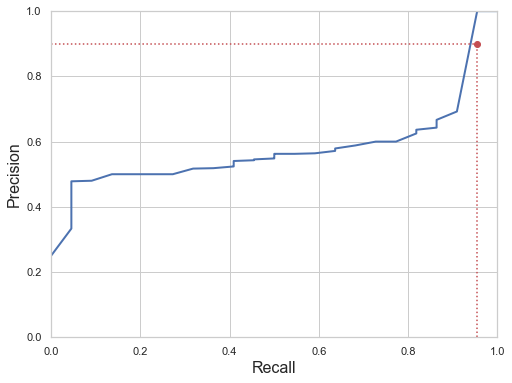

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



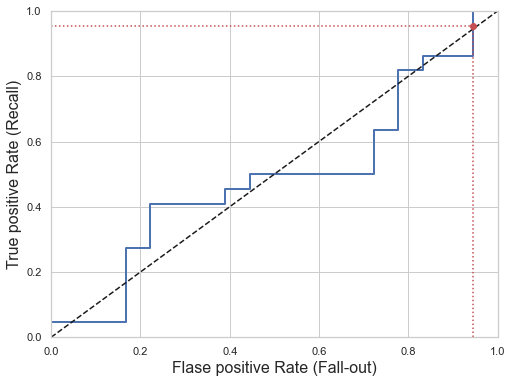

This is the roc_auc_score 0.5463659147869674
Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
__________________________________________________________________________
labels:  [ 1 -1  1 -1  1  1  1  1  1 -1  1 -1 -1 -1  1 -1  1  1  1  1 -1 -1 -1 -1
  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1  1  1 -1  1  1 -1 -1  1 -1  1
  1 -1  1 -1  1  1 -1  1 -1 -1 -1  1  1 -1  1  1 -1  1  1 -1 -1  1 -1 -1
  1 -1 -1  1 -1  1 -1 -1  1 -1  1  1  1  1  1  1  1 -1  1 -1 -1  1 -1 -1
 -1  1  1 -1 -1  1  1 -1 -1 -1 -1  1  1  1 -1  1 -1  1 -1 -1 -1  1 -1 -1
 -1  1  1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1  1  1  1  1  1  1  1  1 -1  1
  1 -1 -1  1  1  1  1 -1 -1 -1 -1  1  1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  1  1  1 -1  1 -1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1  1  1
 -1 -1  1  1 -1  1  1  1]
__________________________________________________________________________
Filtering raw data in 1 contiguous segment
Setting up

    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e+02 (2.2e-16 eps * 59 dim * 5.3e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.8e+02 (2.2e-16 eps * 59 dim * 5.2e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7e+02 (2.2e-16 eps * 59 dim * 5.3e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -

Done.
Computing rank from data with rank=None
    Using tolerance 3.4e+02 (2.2e-16 eps * 59 dim * 2.6e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e+02 (2.2e-16 eps * 59 dim * 2.7e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.3e+02 (2.2e-16 eps * 59 dim * 2.6e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
precisions [0.5        0.48717949 0.47368421 0.45945946 0.47222222 0.45714286
 0.44117647 0.45454545 0.4375     0.4

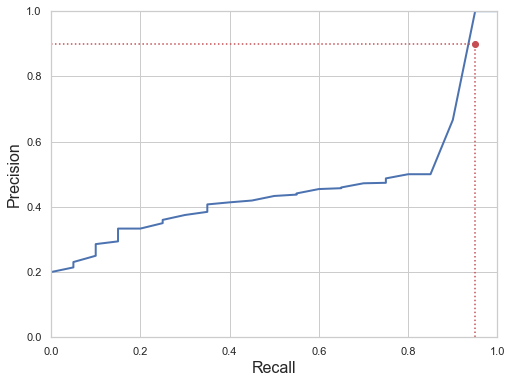

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



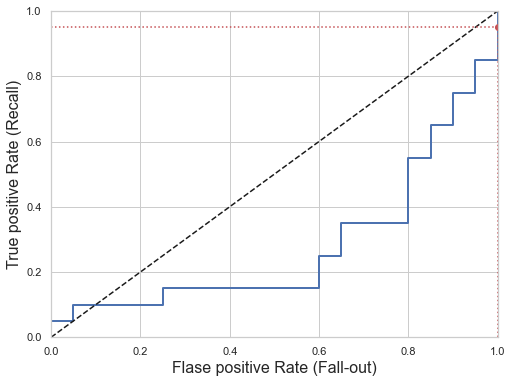

This is the roc_auc_score 0.53125
Creating RawArray with float64 data, n_channels=59, n_times=1906080
    Range : 0 ... 1906079 =      0.000 ...  1906.079 secs
Ready.
__________________________________________________________________________
labels:  [-1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1  1  1  1  1
  1 -1 -1 -1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1 -1  1 -1 -1 -1  1 -1
  1  1  1  1  1 -1  1  1 -1 -1  1  1 -1  1 -1 -1  1 -1 -1  1  1  1 -1  1
  1  1 -1 -1  1 -1 -1  1  1 -1  1  1  1 -1  1 -1 -1  1 -1 -1  1  1  1  1
 -1 -1 -1  1  1 -1 -1  1  1  1  1  1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1
 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1  1  1  1 -1 -1
  1 -1  1  1  1  1  1  1 -1 -1  1  1  1  1 -1 -1  1 -1 -1  1 -1  1 -1  1
 -1  1 -1 -1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1  1 -1 -1  1
  1  1  1 -1  1  1 -1  1]
__________________________________________________________________________
Filtering raw data in 1 contiguous segment
Setting up band-pass 

    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e+03 (2.2e-16 eps * 59 dim * 1.1e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e+03 (2.2e-16 eps * 59 dim * 1.3e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e+03 (2.2e-16 eps * 59 dim * 1.1e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.9e+02 (2.2e-16 eps * 59 dim * 6e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
precisions [0.475      0.46153846 0.47368421 0.48648649 0.5        0.48571429
 

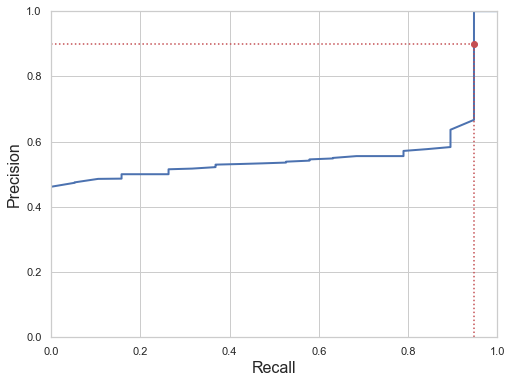

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



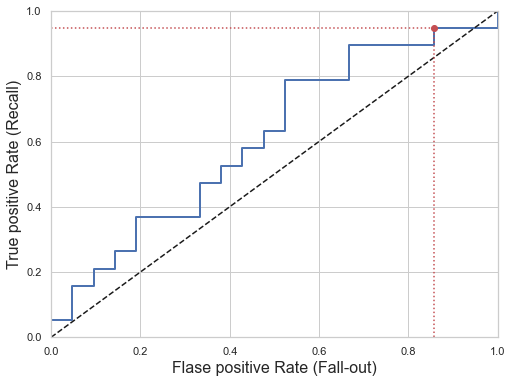

This is the roc_auc_score 0.4782608695652174
Creating RawArray with float64 data, n_channels=59, n_times=1906020
    Range : 0 ... 1906019 =      0.000 ...  1906.019 secs
Ready.
__________________________________________________________________________
labels:  [ 1 -1 -1 -1  1  1 -1  1  1  1  1 -1  1 -1  1 -1  1  1 -1  1 -1 -1  1 -1
 -1 -1  1  1  1 -1 -1  1 -1  1  1 -1  1  1  1  1  1  1  1 -1 -1 -1  1 -1
 -1 -1 -1  1 -1  1  1 -1  1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1  1 -1 -1 -1
 -1  1  1 -1 -1 -1  1  1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
 -1  1  1 -1  1 -1 -1 -1 -1  1  1  1 -1  1 -1  1  1  1 -1  1 -1 -1  1 -1
 -1  1  1 -1  1  1 -1  1 -1 -1  1  1  1 -1 -1  1 -1  1 -1  1  1 -1  1  1
  1 -1  1 -1  1 -1  1  1  1 -1  1 -1 -1 -1  1 -1 -1  1 -1  1 -1 -1  1 -1
 -1 -1 -1  1  1 -1  1 -1  1 -1  1  1 -1  1 -1 -1  1 -1 -1 -1  1  1  1  1
  1 -1 -1 -1 -1 -1  1  1]
__________________________________________________________________________
Filtering raw data in 1 contiguous segment
Setting up

    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.3e+03 (2.2e-16 eps * 59 dim * 2.5e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4e+03 (2.2e-16 eps * 59 dim * 3.1e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e+03 (2.2e-16 eps * 59 dim * 2.7e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -

Done.
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e+03 (2.2e-16 eps * 59 dim * 1.1e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
precisions [0.525      0.51282051 0.5        0.51351351 0.52777778 0.54285714
 0.55882353 0.57575758 0.59375    0.6

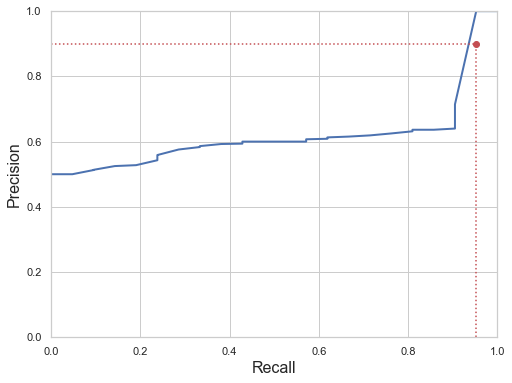

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



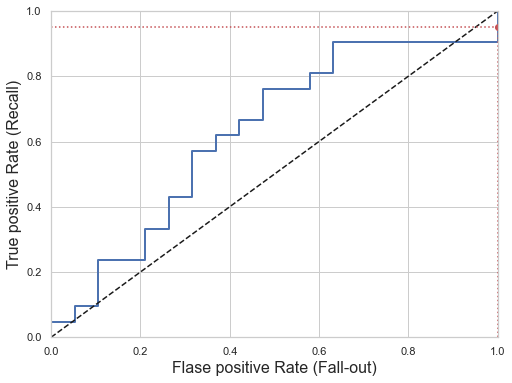

This is the roc_auc_score 0.6239999999999999


In [10]:
"""code from the mne documentation
https://mne.tools/dev/auto_examples/decoding/plot_decoding_csp_eeg.html
This is the LDA classifier pipeline

"""


for f in fp:
    raw = creatRawArray(fp[f])
    events, labels = creatEventsArray(fp[f])
    
    print('__________________________________________________________________________')
    print('labels: ', labels)
    print('__________________________________________________________________________')
    
    # Apply band-pass filter
    raw.filter(low_freq, high_freq, fir_design='firwin', skip_by_annotation='edge')

    # event_train = eventsTrain(fp[f])
    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True,
                        verbose=False)

    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    print('__________________________________________________________________________')
    print('labels after band pass filter: ', labels)
    print('__________________________________________________________________________')

    # labels = epochs.events[:, -1] - 2
    labels = epochs.events[:, -1]


    print('__________________________________________________________________________')
    print('labels after epochs.events change: ', labels)
    print('__________________________________________________________________________')

    # Define a monte-carlo cross-validation generator (reduce variance):
    scores = []
    epochs_data = epochs.get_data()
    epochs_data_train = epochs_train.get_data()
    cv = ShuffleSplit(5, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)
    
    
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(epochs_data_train, labels, test_size=0.2, random_state=42)

    # Assemble a classifier
    lda = LinearDiscriminantAnalysis()
    csp = CSP(n_components=len(epochs.ch_names), reg=None, log=True, norm_trace=False)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = Pipeline([('CSP', csp), ('LDA', lda)])
    scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
    
    print('---------------------------------------------------------------------------------------------------------')
    
    y_train_copy = y_train.copy()
    
    print(y_train)
    for i in range(len(y_train)):
        if -1 == y_train[i]:
            y_train_copy[i] = 0
        else:
            y_train_copy[i] = 1
    
    
    clf.fit(X_train, y_train_copy)
    pred = clf.predict(X_test)
    rmse_train = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("rmse_train:",rmse_train)
    r2_train = float(format(clf.score(X_train, y_train_copy),'.3f'))
    print("r2_train:",r2_train)
    # ar2_train = float(format(adjustedR2(clf.score(X_train, y_train),X_train.shape[0],3),'.3f'))
    mae_train=float(format((metrics.mean_absolute_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("mae_train:",mae_train)
    print('---------------------------------------------------------------------------------------------------------')

    y_test_copy = y_test.copy()
    
    print(y_test)
    for i in range(len(y_test)):
        if -1 == y_test[i]:
            y_test_copy[i] = 0
        else:
            y_test_copy[i] = 1
    print(y_test_copy)
    print('__________________________________________________________________________________')
    
    
    
    rmse_test = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("rmse_test:",rmse_test)
    r2_test = float(format(clf.score(X_test, y_test_copy),'.3f'))
    print("r2_test:",r2_test)
    # ar2_test = float(format(adjustedR2(clf.score(X_test, y_test),X_test.shape[0],3),'.3f'))
    mae_test=float(format((metrics.mean_absolute_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("mae_test:",mae_test)
    print('---------------------------------------------------------------------------------------------------------')

    cv_train = float(format(cross_val_score(clf,X_train, y_train_copy,cv=5).mean(),'.3f'))
    print("cv_train:",cv_train)
    print('---------------------------------------------------------------------------------------------------------')

    cv_test = float(format(cross_val_score(clf,X_test, y_test_copy,cv=5).mean(),'.3f'))
    print("cv_test:",cv_test)
    print('---------------------------------------------------------------------------------------------------------')
    

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
    #making the labels more generalized
    
    print('__________________________________________________________________________________')
    print(pred)

    
    #confusion matrix to know which class is being predicted
    print('__________________________________________________________________________')
    print('confusion matrix: ', confusion_matrix(y_test_copy, pred))
    print('__________________________________________________________________________')
    
#     print("precision_score",precision_score(pred, y_test_copy))
    print("precision_score",precision_score(y_test_copy, pred))
#     print("recall_score",recall_score(pred, y_test_copy))
    print("recall_score",recall_score(y_test_copy, pred))

#     print("f1_score",f1_score(pred, y_test_copy))
    print("f1_score",f1_score(y_test_copy, pred))
    
    
    
    
    #new territory from here
    y_test_dfs = cross_val_predict(clf, X_test, y_test_copy, cv=5, method='decision_function')

    precisions, recalls, thresholds = precision_recall_curve(y_test_copy, y_test_dfs)
    #precisions, recalls, thresholds = precision_recall_curve(y_test_copy, pred)

    print('precisions', precisions)
    precisions.sort()
    print('precisions1 -', precisions[-1])
    print('precisions0 - ', precisions[0])
    print('precisions', precisions.size)
    print('recalls', recalls)
    recalls.sort()
    print('recalls1 -', recalls[-1])
    print('recalls0 -', recalls[0])
    print('recalls', recalls.size)
    print('thresholds', thresholds)
    thresholds.sort()
    print('thresholds1 -', thresholds[-1])
    print('thresholds0 -', thresholds[0])
    print('thresholds', thresholds.size)
    
    #threshold precision recall graph
    recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
    print(recall_90_precision)
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)-1]
    print(threshold_90_precision)


#     plt.figure(figsize=(8, 4))                                                                  
#     plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#     plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
#     plt.plot([-50, threshold_90_precision], [0.9, 0.9], "r:")                                
#     plt.plot([-50, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
#     plt.plot([threshold_90_precision], [0.9], "ro")                                           
#     plt.plot([threshold_90_precision], [recall_90_precision], "ro")                           
#     plt.show()

    plt.figure(figsize=(8, 6))
    plot_precision_vs_recall(precisions, recalls)
    plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
    plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
    plt.plot([recall_90_precision], [0.9], "ro")
    plt.show()
    
    #ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_copy, y_test_dfs)
    #fpr, tpr, thresholds = roc_curve(y_test_copy, pred)

    
    #plot curve
    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr, tpr)
    fpr_90 = fpr[np.argmax( tpr >= recall_90_precision)]
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
    plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
    plt.plot([fpr_90], [recall_90_precision], "ro")
    plt.show()
    
    from sklearn.metrics import roc_auc_score
    print('This is the roc_auc_score', roc_auc_score(pred, y_test_dfs))
    #roc_auc_score(y_test_copy, pred)

Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing r

Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.762
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 1.2e+03 (2.2e-16 eps * 59 dim * 9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3e+02 (2.2e-16 eps * 59 dim * 7.1e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e+03 (2.2e-16 eps * 59 dim * 8.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
R

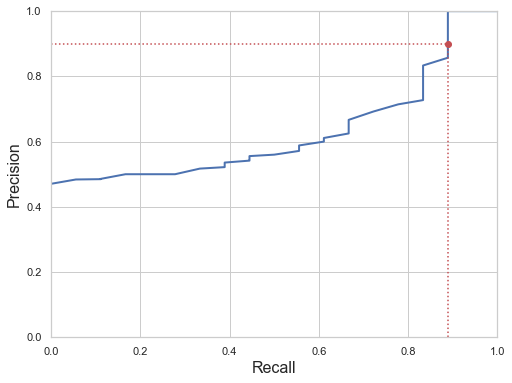

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



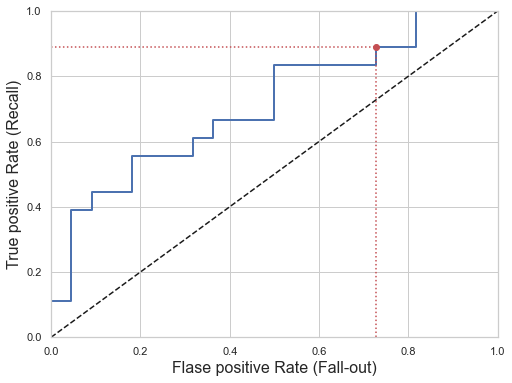

This is the roc_auc_score 0.6565656565656566
Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 7.8e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating

    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.463
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 3.3e+02 (2.2e-16 eps * 59 dim * 2.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e+02 (2.2e-16 eps * 59 dim * 2.6e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e+02 (2.2e-16 eps * 59 dim * 2.6e+16  max singular value)

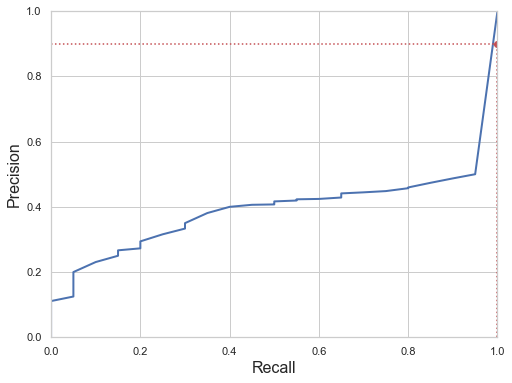

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



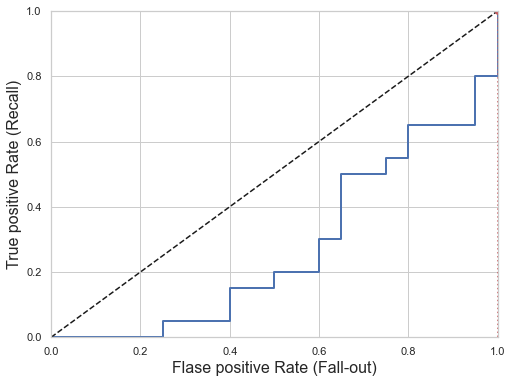

This is the roc_auc_score 0.6785714285714286
Creating RawArray with float64 data, n_channels=59, n_times=1906080
    Range : 0 ... 1906079 =      0.000 ...  1906.079 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating

    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.825
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 7.2e+02 (2.2e-16 eps * 59 dim * 5.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)

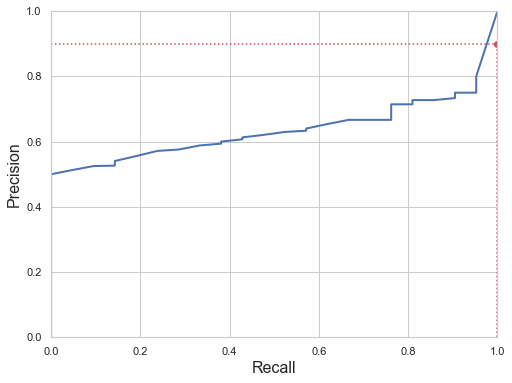

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



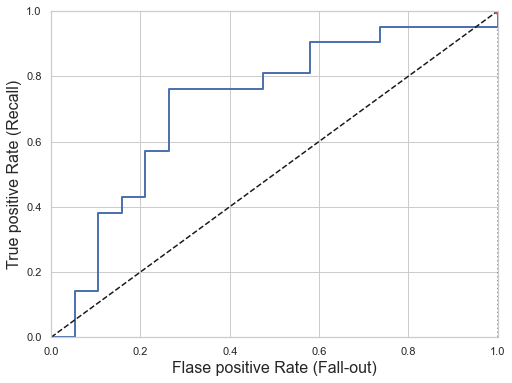

This is the roc_auc_score 0.6165413533834587
Creating RawArray with float64 data, n_channels=59, n_times=1906020
    Range : 0 ... 1906019 =      0.000 ...  1906.019 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 3.8e+03 (2.2e-16 eps * 59 dim * 2.9e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating

    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.881
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)

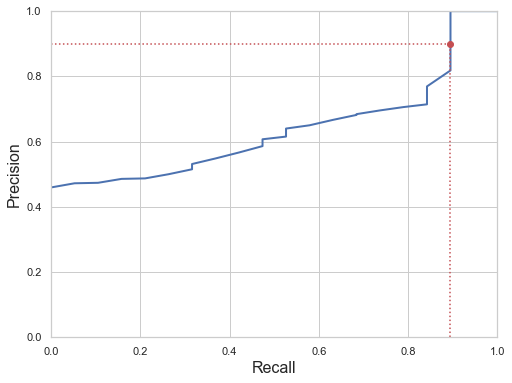

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



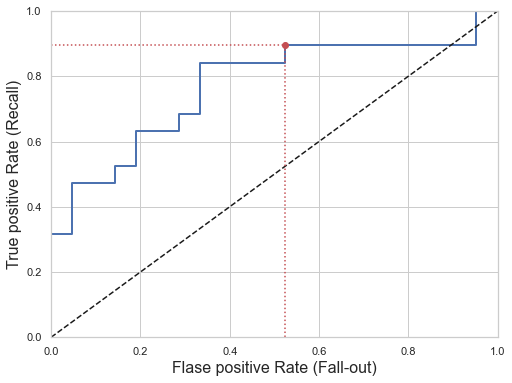

This is the roc_auc_score 0.7263427109974425


In [11]:
"""code from the mne documentation
https://mne.tools/dev/auto_examples/decoding/plot_decoding_csp_eeg.html"""

#this is the SVM classifier
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from mne.decoding import Scaler

for f in fp:
    raw = creatRawArray(fp[f])
    events, labels = creatEventsArray(fp[f])
    
    
    # Apply band-pass filter
    raw.filter(low_freq, high_freq, fir_design='firwin', skip_by_annotation='edge')
    

    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True,
                        verbose=False)#, picks=picks)

    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2

    # Define a monte-carlo cross-validation generator (reduce variance):
    scores = []
    epochs_data = epochs.get_data()
    epochs_data_train = epochs_train.get_data()
    
    #shuffling the data
    cv = ShuffleSplit(5, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)
    
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(epochs_data_train, labels, test_size=0.2, random_state=42)

    # Assemble a classifier
    SVM_C = svm.SVC(kernel='rbf', degree=100)
    csp = CSP(n_components=len(epochs.ch_names), reg=None, log=True, norm_trace=False)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = Pipeline([('CSP', csp), ('SVM_C', SVM_C)])
    scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
    
    print('---------------------------------------------------------------------------------------------------------')
    
    y_train_copy = y_train.copy()
    
    print(y_train)
    for i in range(len(y_train)):
        if -1 == y_train[i]:
            y_train_copy[i] = 0
        else:
            y_train_copy[i] = 1
    
    
    clf.fit(X_train, y_train_copy)
    pred = clf.predict(X_test)
    rmse_train = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("rmse_train:",rmse_train)
    r2_train = float(format(clf.score(X_train, y_train_copy),'.3f'))
    print("r2_train:",r2_train)
    # ar2_train = float(format(adjustedR2(clf.score(X_train, y_train),X_train.shape[0],3),'.3f'))
    mae_train=float(format((metrics.mean_absolute_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("mae_train:",mae_train)
    print('---------------------------------------------------------------------------------------------------------')

    y_test_copy = y_test.copy()
    
    print(y_test)
    for i in range(len(y_test)):
        if -1 == y_test[i]:
            y_test_copy[i] = 0
        else:
            y_test_copy[i] = 1
    print(y_test_copy)
    print('__________________________________________________________________________________')
    
    
    
    rmse_test = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("rmse_test:",rmse_test)
    r2_test = float(format(clf.score(X_test, y_test_copy),'.3f'))
    print("r2_test:",r2_test)
    # ar2_test = float(format(adjustedR2(clf.score(X_test, y_test),X_test.shape[0],3),'.3f'))
    mae_test=float(format((metrics.mean_absolute_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("mae_test:",mae_test)
    print('---------------------------------------------------------------------------------------------------------')

    cv_train = float(format(cross_val_score(clf,X_train, y_train_copy,cv=5).mean(),'.3f'))
    print("cv_train:",cv_train)
    print('---------------------------------------------------------------------------------------------------------')

    cv_test = float(format(cross_val_score(clf,X_test, y_test_copy,cv=5).mean(),'.3f'))
    print("cv_test:",cv_test)
    print('---------------------------------------------------------------------------------------------------------')
    

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
    #making the labels more generalized
    
    print('__________________________________________________________________________________')
    print(pred)
    
    #confusion matrix to know which class is being predicted
    print('__________________________________________________________________________')
    print('confusion matrix: ', confusion_matrix(y_test_copy, pred))
    print('__________________________________________________________________________')

#     print("precision_score",precision_score(pred, y_test_copy))
    print("precision_score",precision_score(y_test_copy, pred))
#     print("recall_score",recall_score(pred, y_test_copy))
    print("recall_score",recall_score(y_test_copy, pred))

#     print("f1_score",f1_score(pred, y_test_copy))
    print("f1_score",f1_score(y_test_copy, pred))
    
    
    
    
    #new territory from here
    y_test_dfs = cross_val_predict(clf, X_test, y_test_copy, cv=5, method='decision_function')

    precisions, recalls, thresholds = precision_recall_curve(y_test_copy, y_test_dfs)
    #precisions, recalls, thresholds = precision_recall_curve(y_test_copy, pred)

    print('precisions', precisions)
    precisions.sort()
    print('precisions1 -', precisions[-1])
    print('precisions0 - ', precisions[0])
    print('precisions', precisions.size)
    print('recalls', recalls)
    recalls.sort()
    print('recalls1 -', recalls[-1])
    print('recalls0 -', recalls[0])
    print('recalls', recalls.size)
    print('thresholds', thresholds)
    thresholds.sort()
    print('thresholds1 -', thresholds[-1])
    print('thresholds0 -', thresholds[0])
    print('thresholds', thresholds.size)
    
    #threshold precision recall graph
    recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
    print(recall_90_precision)
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)-1]
    print(threshold_90_precision)


#     plt.figure(figsize=(8, 4))                                                                  
#     plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#     plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
#     plt.plot([-50, threshold_90_precision], [0.9, 0.9], "r:")                                
#     plt.plot([-50, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
#     plt.plot([threshold_90_precision], [0.9], "ro")                                           
#     plt.plot([threshold_90_precision], [recall_90_precision], "ro")                           
#     plt.show()

    plt.figure(figsize=(8, 6))
    plot_precision_vs_recall(precisions, recalls)
    plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
    plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
    plt.plot([recall_90_precision], [0.9], "ro")
    plt.show()
    
    #ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_copy, y_test_dfs)
    #fpr, tpr, thresholds = roc_curve(y_test_copy, pred)

    
    #plot curve
    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr, tpr)
    fpr_90 = fpr[np.argmax( tpr >= recall_90_precision)]
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
    plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
    plt.plot([fpr_90], [recall_90_precision], "ro")
    plt.show()
    
    from sklearn.metrics import roc_auc_score
    print('This is the roc_auc_score', roc_auc_score(pred, y_test_dfs))
    #roc_auc_score(y_test_copy, pred)

Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing r

Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.756
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 1.2e+03 (2.2e-16 eps * 59 dim * 9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3e+02 (2.2e-16 eps * 59 dim * 7.1e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e+03 (2.2e-16 eps * 59 dim * 8.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
R

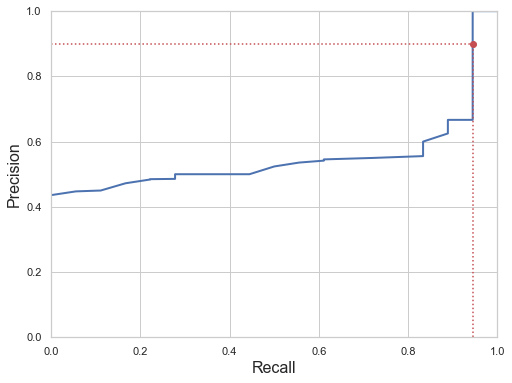

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



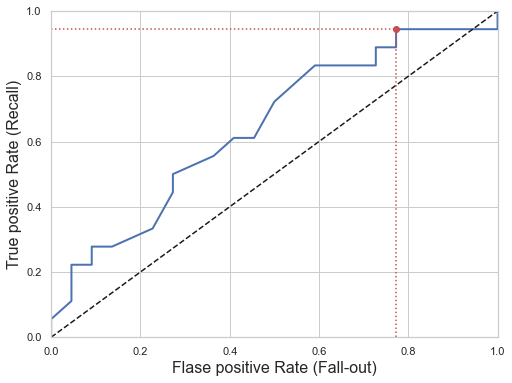

This is the roc_auc_score 0.608695652173913
Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 7.8e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating 

    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.444
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 3.3e+02 (2.2e-16 eps * 59 dim * 2.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e+02 (2.2e-16 eps * 59 dim * 2.6e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e+02 (2.2e-16 eps * 59 dim * 2.6e+16  max singular value)
    Estimated rank (mag): 59

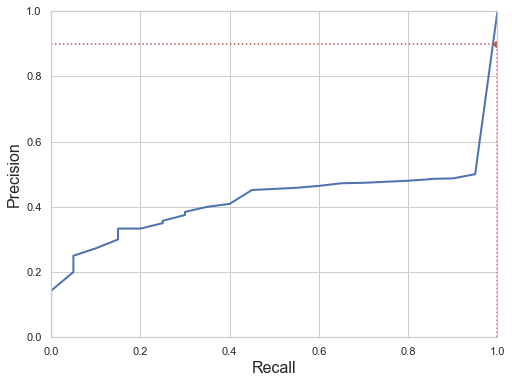

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



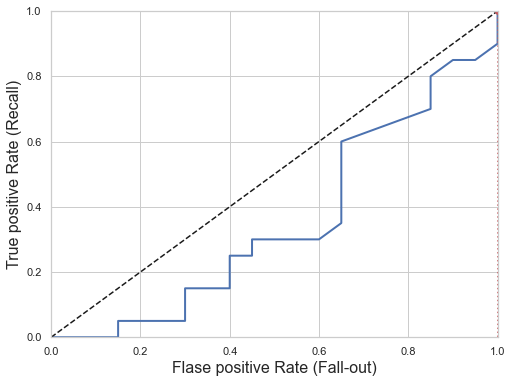

This is the roc_auc_score 0.5742187500000001
Creating RawArray with float64 data, n_channels=59, n_times=1906080
    Range : 0 ... 1906079 =      0.000 ...  1906.079 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating

    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.762
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 7.2e+02 (2.2e-16 eps * 59 dim * 5.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)

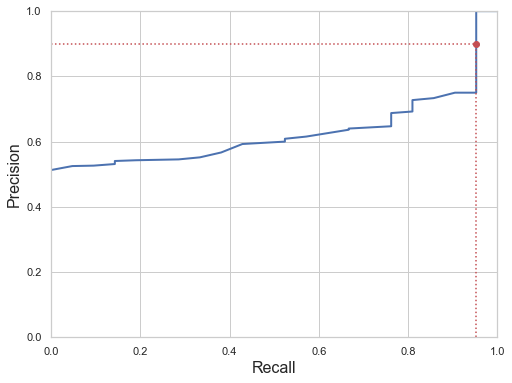

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



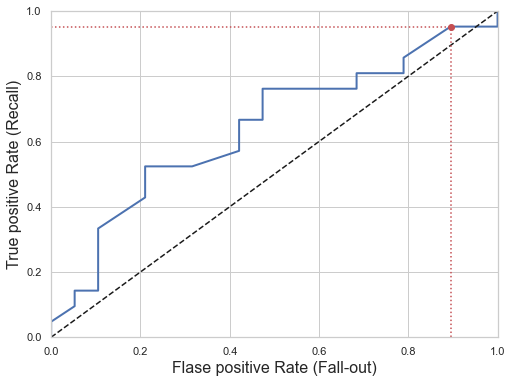

This is the roc_auc_score 0.77625
Creating RawArray with float64 data, n_channels=59, n_times=1906020
    Range : 0 ... 1906019 =      0.000 ...  1906.019 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 3.8e+03 (2.2e-16 eps * 59 dim * 2.9e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance

    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.85
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59


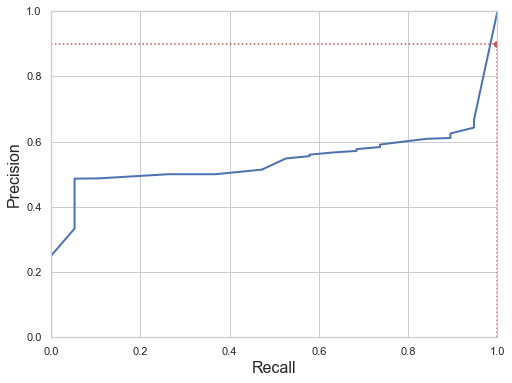

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



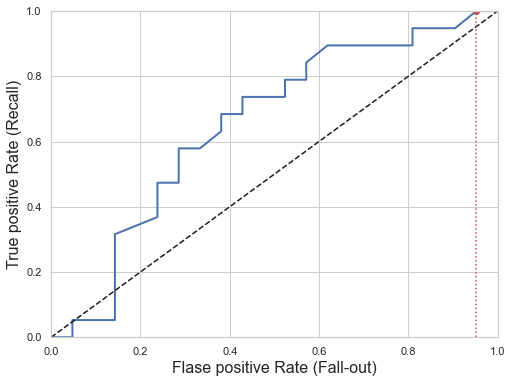

This is the roc_auc_score 0.5288220551378446


In [12]:
"""code from the mne documentation
https://mne.tools/dev/auto_examples/decoding/plot_decoding_csp_eeg.html"""

#this is the Random Forest classifier
from sklearn.ensemble import RandomForestClassifier


for f in fp:
    raw = creatRawArray(fp[f])
    events, labels = creatEventsArray(fp[f])
    
    
    # Apply band-pass filter
    raw.filter(low_freq, high_freq, fir_design='firwin', skip_by_annotation='edge')
 
    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True,
                        verbose=False)#, picks=picks)

    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2

    # Define a monte-carlo cross-validation generator (reduce variance):
    scores = []
    epochs_data = epochs.get_data()
    epochs_data_train = epochs_train.get_data()
    
    #shuffling the data
    cv = ShuffleSplit(5, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)
    
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(epochs_data_train, labels, test_size=0.2, random_state=42)

    # Assemble a classifier
    RFC = RandomForestClassifier()
    csp = CSP(n_components=len(epochs.ch_names), reg=None, log=True, norm_trace=False)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = Pipeline([('CSP', csp), ('RFC', RFC)])
    scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
    
    print('---------------------------------------------------------------------------------------------------------')
    
    y_train_copy = y_train.copy()
    
    print(y_train)
    for i in range(len(y_train)):
        if -1 == y_train[i]:
            y_train_copy[i] = 0
        else:
            y_train_copy[i] = 1
    
    
    clf.fit(X_train, y_train_copy)
    pred = clf.predict(X_test)
    rmse_train = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("rmse_train:",rmse_train)
    r2_train = float(format(clf.score(X_train, y_train_copy),'.3f'))
    print("r2_train:",r2_train)
    # ar2_train = float(format(adjustedR2(clf.score(X_train, y_train),X_train.shape[0],3),'.3f'))
    mae_train=float(format((metrics.mean_absolute_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("mae_train:",mae_train)
    print('---------------------------------------------------------------------------------------------------------')

    y_test_copy = y_test.copy()
    
    print(y_test)
    for i in range(len(y_test)):
        if -1 == y_test[i]:
            y_test_copy[i] = 0
        else:
            y_test_copy[i] = 1
    print(y_test_copy)
    print('__________________________________________________________________________________')
    
    
    
    rmse_test = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("rmse_test:",rmse_test)
    r2_test = float(format(clf.score(X_test, y_test_copy),'.3f'))
    print("r2_test:",r2_test)
    # ar2_test = float(format(adjustedR2(clf.score(X_test, y_test),X_test.shape[0],3),'.3f'))
    mae_test=float(format((metrics.mean_absolute_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("mae_test:",mae_test)
    print('---------------------------------------------------------------------------------------------------------')

    cv_train = float(format(cross_val_score(clf,X_train, y_train_copy,cv=5).mean(),'.3f'))
    print("cv_train:",cv_train)
    print('---------------------------------------------------------------------------------------------------------')

    cv_test = float(format(cross_val_score(clf,X_test, y_test_copy,cv=5).mean(),'.3f'))
    print("cv_test:",cv_test)
    print('---------------------------------------------------------------------------------------------------------')
    

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
    #making the labels more generalized
    
    print('__________________________________________________________________________________')
    print(pred)
    
    #confusion matrix to know which class is being predicted
    print('__________________________________________________________________________')
    print('confusion matrix: ', confusion_matrix(y_test_copy, pred))
    print('__________________________________________________________________________')

#     print("precision_score",precision_score(pred, y_test_copy))
    print("precision_score",precision_score(y_test_copy, pred))
#     print("recall_score",recall_score(pred, y_test_copy))
    print("recall_score",recall_score(y_test_copy, pred))

#     print("f1_score",f1_score(pred, y_test_copy))
    print("f1_score",f1_score(y_test_copy, pred))
    
    
    
    
    #new territory from here
    y_probas = cross_val_predict(clf, X_test, y_test_copy, cv=5, method='predict_proba')
    
    y_test_dfs = y_probas[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_test_copy, y_test_dfs)
    #precisions, recalls, thresholds = precision_recall_curve(y_test_copy, pred)

    print('precisions', precisions)
    precisions.sort()
    print('precisions1 -', precisions[-1])
    print('precisions0 - ', precisions[0])
    print('precisions', precisions.size)
    print('recalls', recalls)
    recalls.sort()
    print('recalls1 -', recalls[-1])
    print('recalls0 -', recalls[0])
    print('recalls', recalls.size)
    print('thresholds', thresholds)
    thresholds.sort()
    print('thresholds1 -', thresholds[-1])
    print('thresholds0 -', thresholds[0])
    print('thresholds', thresholds.size)
    
    #threshold precision recall graph
    recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
    print(recall_90_precision)
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)-1]
    print(threshold_90_precision)


#     plt.figure(figsize=(8, 4))                                                                  
#     plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#     plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
#     plt.plot([-50, threshold_90_precision], [0.9, 0.9], "r:")                                
#     plt.plot([-50, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
#     plt.plot([threshold_90_precision], [0.9], "ro")                                           
#     plt.plot([threshold_90_precision], [recall_90_precision], "ro")                           
#     plt.show()

    plt.figure(figsize=(8, 6))
    plot_precision_vs_recall(precisions, recalls)
    plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
    plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
    plt.plot([recall_90_precision], [0.9], "ro")
    plt.show()
    
    #ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_copy, y_test_dfs)
    #fpr, tpr, thresholds = roc_curve(y_test_copy, pred)

    
    #plot curve
    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr, tpr)
    fpr_90 = fpr[np.argmax( tpr >= recall_90_precision)]
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
    plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
    plt.plot([fpr_90], [recall_90_precision], "ro")
    plt.show()
    
    from sklearn.metrics import roc_auc_score
    print('This is the roc_auc_score', roc_auc_score(pred, y_test_dfs))
    #roc_auc_score(y_test_copy, pred)

Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing r

Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.756
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 1.2e+03 (2.2e-16 eps * 59 dim * 9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3e+02 (2.2e-16 eps * 59 dim * 7.1e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e+03 (2.2e-16 eps * 59 dim * 8.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
R

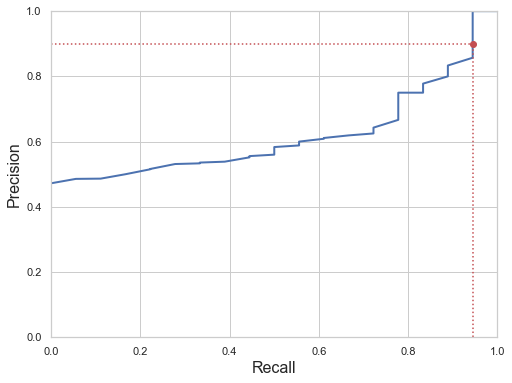

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



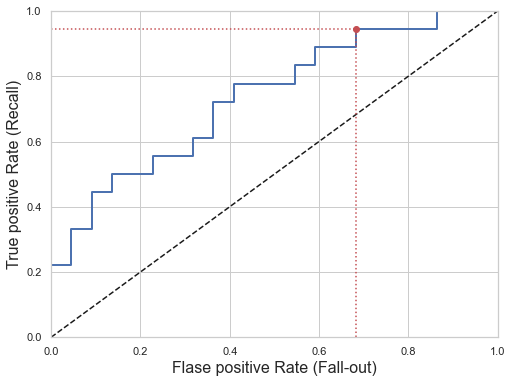

This is the roc_auc_score 0.7095959595959597
Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 7.8e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating

    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.494
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 3.3e+02 (2.2e-16 eps * 59 dim * 2.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e+02 (2.2e-16 eps * 59 dim * 2.6e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e+02 (2.2e-16 eps * 59 dim * 2.6e+16  max singular value)
    Estimated rank (mag): 59

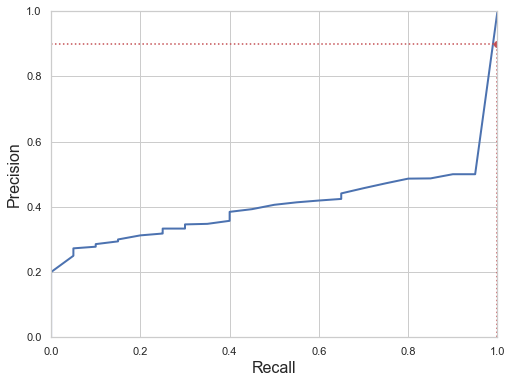

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



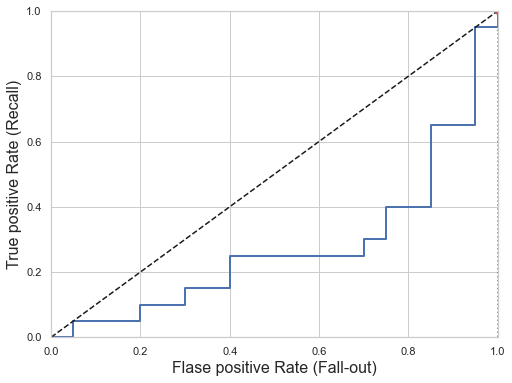

This is the roc_auc_score 0.4895833333333333
Creating RawArray with float64 data, n_channels=59, n_times=1906080
    Range : 0 ... 1906079 =      0.000 ...  1906.079 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating

    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.744
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 7.2e+02 (2.2e-16 eps * 59 dim * 5.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)

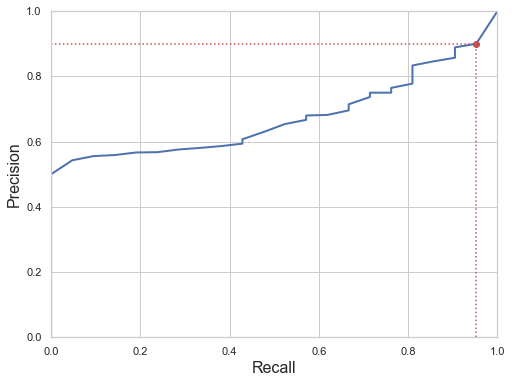

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



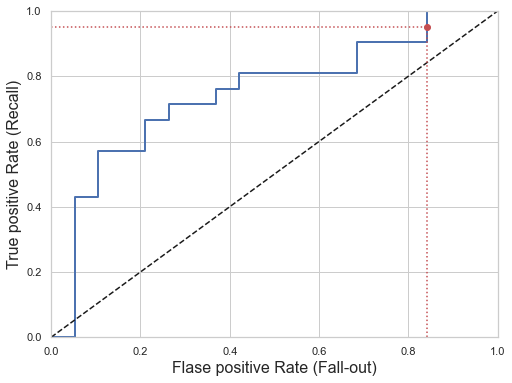

This is the roc_auc_score 0.6035353535353536
Creating RawArray with float64 data, n_channels=59, n_times=1906020
    Range : 0 ... 1906019 =      0.000 ...  1906.019 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 3.8e+03 (2.2e-16 eps * 59 dim * 2.9e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating

    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.894
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)

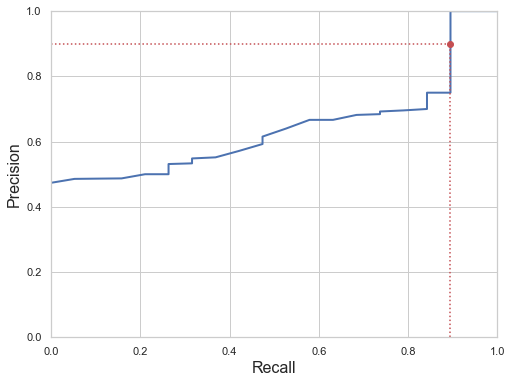

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



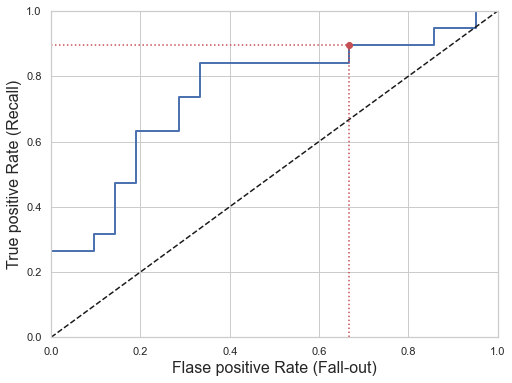

This is the roc_auc_score 0.8005115089514065


In [13]:
"""code from the mne documentation
https://mne.tools/dev/auto_examples/decoding/plot_decoding_csp_eeg.html"""

#this is the MLP neural net classifier
from sklearn.neural_network import MLPClassifier


for f in fp:
    raw = creatRawArray(fp[f])
    events, labels = creatEventsArray(fp[f])    
    
    # Apply band-pass filter
    raw.filter(low_freq, high_freq, fir_design='firwin', skip_by_annotation='edge')
    

    # event_train = eventsTrain(fp[f])
    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True,
                        verbose=False)#, picks=picks)

    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2

    # Define a monte-carlo cross-validation generator (reduce variance):
    scores = []
    epochs_data = epochs.get_data()
    epochs_data_train = epochs_train.get_data()
    
    #shuffling the data
    cv = ShuffleSplit(5, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)
    
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(epochs_data_train, labels, test_size=0.2, random_state=42)

    # Assemble a classifier
    MLP_C = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16, 16), random_state=42)
    csp = CSP(n_components=len(epochs.ch_names), reg=None, log=True, norm_trace=False)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = Pipeline([('CSP', csp), ('MLP_C', MLP_C)])
    scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
    
    print('---------------------------------------------------------------------------------------------------------')
    
    y_train_copy = y_train.copy()
    
    print(y_train)
    for i in range(len(y_train)):
        if -1 == y_train[i]:
            y_train_copy[i] = 0
        else:
            y_train_copy[i] = 1
    
    
    clf.fit(X_train, y_train_copy)
    pred = clf.predict(X_test)
    rmse_train = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("rmse_train:",rmse_train)
    r2_train = float(format(clf.score(X_train, y_train_copy),'.3f'))
    print("r2_train:",r2_train)
    # ar2_train = float(format(adjustedR2(clf.score(X_train, y_train),X_train.shape[0],3),'.3f'))
    mae_train=float(format((metrics.mean_absolute_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("mae_train:",mae_train)
    print('---------------------------------------------------------------------------------------------------------')

    y_test_copy = y_test.copy()
    
    print(y_test)
    for i in range(len(y_test)):
        if -1 == y_test[i]:
            y_test_copy[i] = 0
        else:
            y_test_copy[i] = 1
    print(y_test_copy)
    print('__________________________________________________________________________________')
    
    
    
    rmse_test = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("rmse_test:",rmse_test)
    r2_test = float(format(clf.score(X_test, y_test_copy),'.3f'))
    print("r2_test:",r2_test)
    # ar2_test = float(format(adjustedR2(clf.score(X_test, y_test),X_test.shape[0],3),'.3f'))
    mae_test=float(format((metrics.mean_absolute_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("mae_test:",mae_test)
    print('---------------------------------------------------------------------------------------------------------')

    cv_train = float(format(cross_val_score(clf,X_train, y_train_copy,cv=5).mean(),'.3f'))
    print("cv_train:",cv_train)
    print('---------------------------------------------------------------------------------------------------------')

    cv_test = float(format(cross_val_score(clf,X_test, y_test_copy,cv=5).mean(),'.3f'))
    print("cv_test:",cv_test)
    print('---------------------------------------------------------------------------------------------------------')
    

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
    #making the labels more generalized
    
    print('__________________________________________________________________________________')
    print(pred)
    
    #confusion matrix to know which class is being predicted
    print('__________________________________________________________________________')
    print('confusion matrix: ', confusion_matrix(y_test_copy, pred))
    print('__________________________________________________________________________')

#     print("precision_score",precision_score(pred, y_test_copy))
    print("precision_score",precision_score(y_test_copy, pred))
#     print("recall_score",recall_score(pred, y_test_copy))
    print("recall_score",recall_score(y_test_copy, pred))

#     print("f1_score",f1_score(pred, y_test_copy))
    print("f1_score",f1_score(y_test_copy, pred))
    
    
    
    
    #new territory from here
    y_probas = cross_val_predict(clf, X_test, y_test_copy, cv=5, method='predict_proba')
    
    y_test_dfs = y_probas[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_test_copy, y_test_dfs)
    #precisions, recalls, thresholds = precision_recall_curve(y_test_copy, pred)

    print('precisions', precisions)
    precisions.sort()
    print('precisions1 -', precisions[-1])
    print('precisions0 - ', precisions[0])
    print('precisions', precisions.size)
    print('recalls', recalls)
    recalls.sort()
    print('recalls1 -', recalls[-1])
    print('recalls0 -', recalls[0])
    print('recalls', recalls.size)
    print('thresholds', thresholds)
    thresholds.sort()
    print('thresholds1 -', thresholds[-1])
    print('thresholds0 -', thresholds[0])
    print('thresholds', thresholds.size)
    
    #threshold precision recall graph
    recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
    print(recall_90_precision)
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)-1]
    print(threshold_90_precision)


#     plt.figure(figsize=(8, 4))                                                                  
#     plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#     plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
#     plt.plot([-50, threshold_90_precision], [0.9, 0.9], "r:")                                
#     plt.plot([-50, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
#     plt.plot([threshold_90_precision], [0.9], "ro")                                           
#     plt.plot([threshold_90_precision], [recall_90_precision], "ro")                           
#     plt.show()

    plt.figure(figsize=(8, 6))
    plot_precision_vs_recall(precisions, recalls)
    plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
    plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
    plt.plot([recall_90_precision], [0.9], "ro")
    plt.show()
    
    #ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_copy, y_test_dfs)
    #fpr, tpr, thresholds = roc_curve(y_test_copy, pred)

    
    #plot curve
    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr, tpr)
    fpr_90 = fpr[np.argmax( tpr >= recall_90_precision)]
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
    plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
    plt.plot([fpr_90], [recall_90_precision], "ro")
    plt.show()
    
    from sklearn.metrics import roc_auc_score
    print('This is the roc_auc_score', roc_auc_score(pred, y_test_dfs))
    #roc_auc_score(y_test_copy, pred)

Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing r

Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.756
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 1.2e+03 (2.2e-16 eps * 59 dim * 9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3e+02 (2.2e-16 eps * 59 dim * 7.1e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e+03 (2.2e-16 eps * 59 dim * 8.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
R

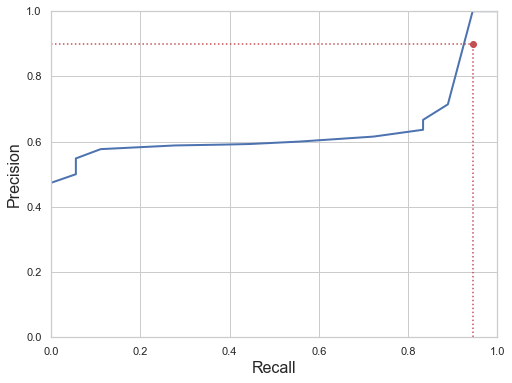

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



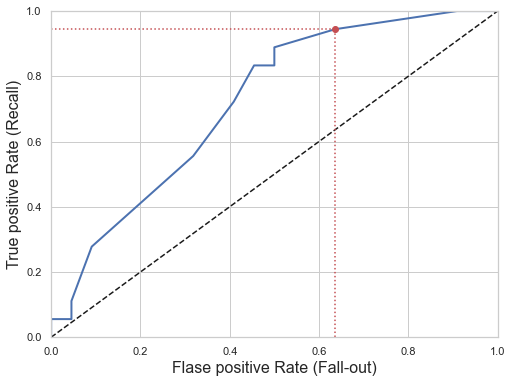

This is the roc_auc_score 0.7442455242966752
Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 7.8e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating

    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.463
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 3.3e+02 (2.2e-16 eps * 59 dim * 2.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e+02 (2.2e-16 eps * 59 dim * 2.6e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e+02 (2.2e-16 eps * 59 dim * 2.6e+16  max singular value)

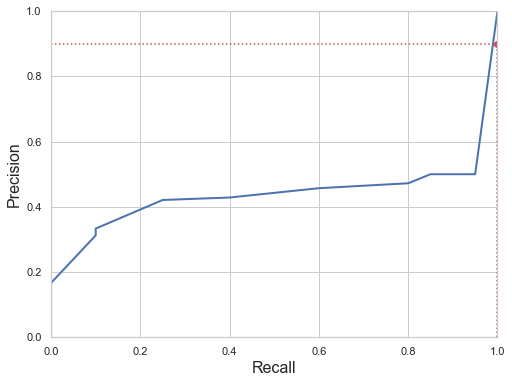

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



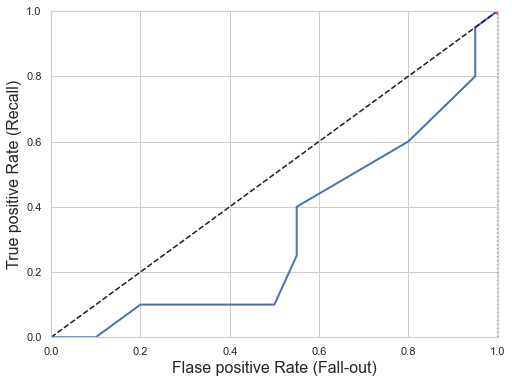

This is the roc_auc_score 0.5729166666666666
Creating RawArray with float64 data, n_channels=59, n_times=1906080
    Range : 0 ... 1906079 =      0.000 ...  1906.079 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating

    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.806
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 7.2e+02 (2.2e-16 eps * 59 dim * 5.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)

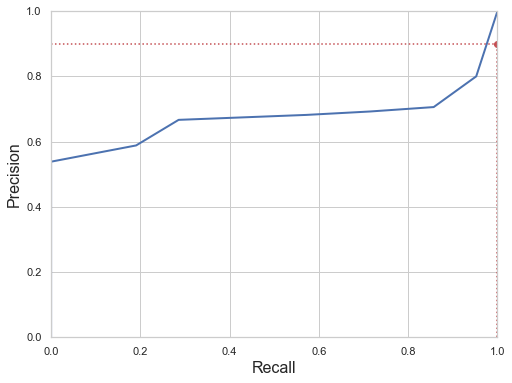

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



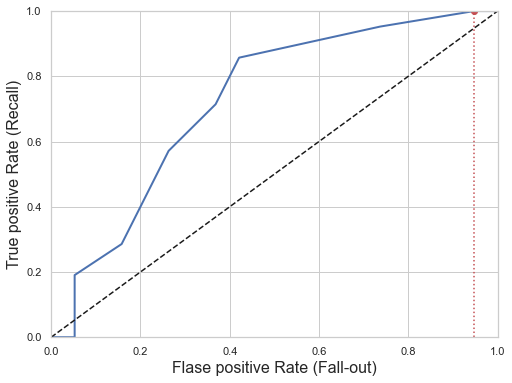

This is the roc_auc_score 0.6363636363636364
Creating RawArray with float64 data, n_channels=59, n_times=1906020
    Range : 0 ... 1906019 =      0.000 ...  1906.019 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 3.8e+03 (2.2e-16 eps * 59 dim * 2.9e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating

    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.875
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)

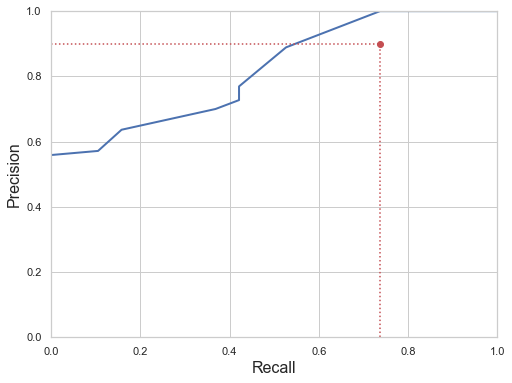

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



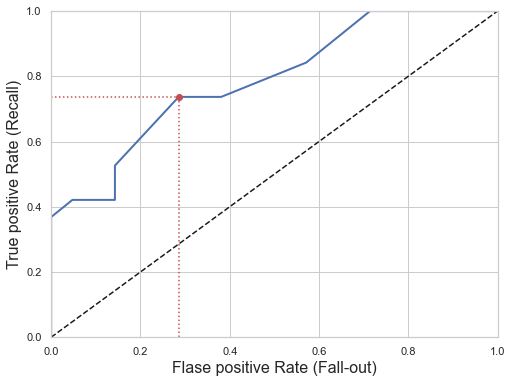

This is the roc_auc_score 0.7239583333333333


In [14]:
"""code reference from the mne documentation
https://www.researchgate.net/publication/321726030_The_Performance_Analysis_of_K-Nearest_Neighbors_K-NN_Algorithm_for_Motor_Imagery_Classification_Based_on_EEG_Signal

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

"""

#this is the Knearest neighbour classifier
from sklearn.neighbors import KNeighborsClassifier


for f in fp:
    raw = creatRawArray(fp[f])
    events, labels = creatEventsArray(fp[f])
        
    
    # Apply band-pass filter
    raw.filter(low_freq, high_freq, fir_design='firwin', skip_by_annotation='edge')
    
    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True,
                        verbose=False)#, picks=picks)

    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2

    # Define a monte-carlo cross-validation generator (reduce variance):
    scores = []
    epochs_data = epochs.get_data()
    epochs_data_train = epochs_train.get_data()
    
    #shuffling the data
    cv = ShuffleSplit(5, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)
    
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(epochs_data_train, labels, test_size=0.2, random_state=42)

    # Assemble a classifier
    KNN_C = KNeighborsClassifier(n_neighbors=15, algorithm='auto', n_jobs=1, metric='chebyshev')
    csp = CSP(n_components=len(epochs.ch_names), reg=None, log=True, norm_trace=False)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = Pipeline([('CSP', csp), ('KNN_C', KNN_C)])
    scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
    
    print('---------------------------------------------------------------------------------------------------------')
    
    y_train_copy = y_train.copy()
    
    print(y_train)
    for i in range(len(y_train)):
        if -1 == y_train[i]:
            y_train_copy[i] = 0
        else:
            y_train_copy[i] = 1
    
    
    clf.fit(X_train, y_train_copy)
    pred = clf.predict(X_test)
    rmse_train = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("rmse_train:",rmse_train)
    r2_train = float(format(clf.score(X_train, y_train_copy),'.3f'))
    print("r2_train:",r2_train)
    # ar2_train = float(format(adjustedR2(clf.score(X_train, y_train),X_train.shape[0],3),'.3f'))
    mae_train=float(format((metrics.mean_absolute_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("mae_train:",mae_train)
    print('---------------------------------------------------------------------------------------------------------')

    y_test_copy = y_test.copy()
    
    print(y_test)
    for i in range(len(y_test)):
        if -1 == y_test[i]:
            y_test_copy[i] = 0
        else:
            y_test_copy[i] = 1
    print(y_test_copy)
    print('__________________________________________________________________________________')
    
    
    
    rmse_test = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("rmse_test:",rmse_test)
    r2_test = float(format(clf.score(X_test, y_test_copy),'.3f'))
    print("r2_test:",r2_test)
    # ar2_test = float(format(adjustedR2(clf.score(X_test, y_test),X_test.shape[0],3),'.3f'))
    mae_test=float(format((metrics.mean_absolute_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("mae_test:",mae_test)
    print('---------------------------------------------------------------------------------------------------------')

    cv_train = float(format(cross_val_score(clf,X_train, y_train_copy,cv=5).mean(),'.3f'))
    print("cv_train:",cv_train)
    print('---------------------------------------------------------------------------------------------------------')

    cv_test = float(format(cross_val_score(clf,X_test, y_test_copy,cv=5).mean(),'.3f'))
    print("cv_test:",cv_test)
    print('---------------------------------------------------------------------------------------------------------')
    

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
    #making the labels more generalized
    
    print('__________________________________________________________________________________')
    print(pred)
    
    #confusion matrix to know which class is being predicted
    print('__________________________________________________________________________')
    print('confusion matrix: ', confusion_matrix(y_test_copy, pred))
    print('__________________________________________________________________________')

#     print("precision_score",precision_score(pred, y_test_copy))
    print("precision_score",precision_score(y_test_copy, pred))
#     print("recall_score",recall_score(pred, y_test_copy))
    print("recall_score",recall_score(y_test_copy, pred))

#     print("f1_score",f1_score(pred, y_test_copy))
    print("f1_score",f1_score(y_test_copy, pred))
    
    
    
    
    #new territory from here
    y_probas = cross_val_predict(clf, X_test, y_test_copy, cv=5, method='predict_proba')
    
    y_test_dfs = y_probas[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_test_copy, y_test_dfs)
    #precisions, recalls, thresholds = precision_recall_curve(y_test_copy, pred)

    print('precisions', precisions)
    precisions.sort()
    print('precisions1 -', precisions[-1])
    print('precisions0 - ', precisions[0])
    print('precisions', precisions.size)
    print('recalls', recalls)
    recalls.sort()
    print('recalls1 -', recalls[-1])
    print('recalls0 -', recalls[0])
    print('recalls', recalls.size)
    print('thresholds', thresholds)
    thresholds.sort()
    print('thresholds1 -', thresholds[-1])
    print('thresholds0 -', thresholds[0])
    print('thresholds', thresholds.size)
    
    #threshold precision recall graph
    recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
    print(recall_90_precision)
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)-1]
    print(threshold_90_precision)


#     plt.figure(figsize=(8, 4))                                                                  
#     plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#     plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
#     plt.plot([-50, threshold_90_precision], [0.9, 0.9], "r:")                                
#     plt.plot([-50, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
#     plt.plot([threshold_90_precision], [0.9], "ro")                                           
#     plt.plot([threshold_90_precision], [recall_90_precision], "ro")                           
#     plt.show()

    plt.figure(figsize=(8, 6))
    plot_precision_vs_recall(precisions, recalls)
    plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
    plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
    plt.plot([recall_90_precision], [0.9], "ro")
    plt.show()
    
    #ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_copy, y_test_dfs)
    #fpr, tpr, thresholds = roc_curve(y_test_copy, pred)

    
    #plot curve
    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr, tpr)
    fpr_90 = fpr[np.argmax( tpr >= recall_90_precision)]
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
    plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
    plt.plot([fpr_90], [recall_90_precision], "ro")
    plt.show()
    
    from sklearn.metrics import roc_auc_score
    print('This is the roc_auc_score', roc_auc_score(pred, y_test_dfs))
    #roc_auc_score(y_test_copy, pred)

Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing r

Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.7
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 1.2e+03 (2.2e-16 eps * 59 dim * 9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3e+02 (2.2e-16 eps * 59 dim * 7.1e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e+03 (2.2e-16 eps * 59 dim * 8.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Red

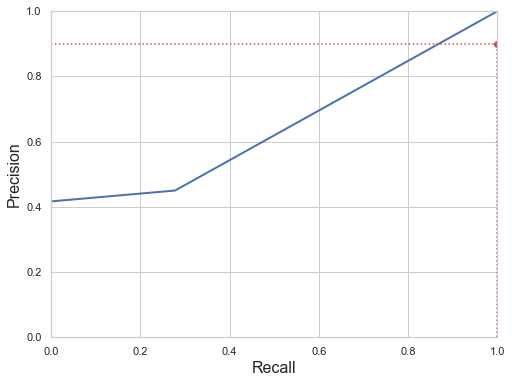

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



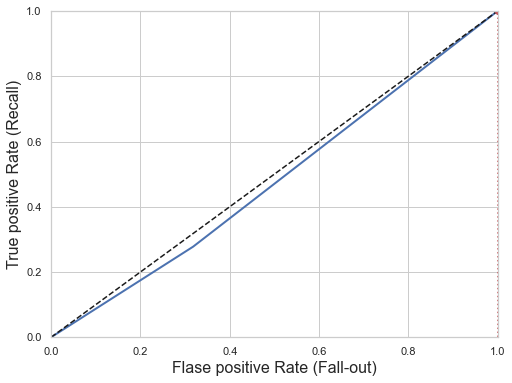

This is the roc_auc_score 0.4487179487179488
Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 7.8e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating

    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.456
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 3.3e+02 (2.2e-16 eps * 59 dim * 2.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e+02 (2.2e-16 eps * 59 dim * 2.6e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e+02 (2.2e-16 eps * 59 dim * 2.6e+16  max singular value)
    Estimated rank (mag): 59

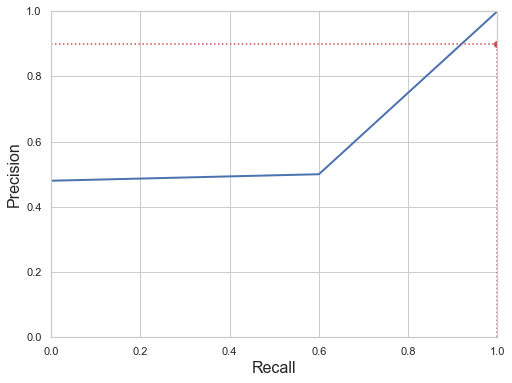

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



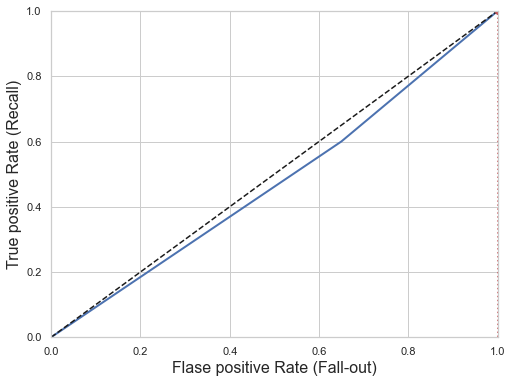

This is the roc_auc_score 0.475
Creating RawArray with float64 data, n_channels=59, n_times=1906080
    Range : 0 ... 1906079 =      0.000 ...  1906.079 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance u

    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.731
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 7.2e+02 (2.2e-16 eps * 59 dim * 5.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)
    Estimated rank (mag): 59

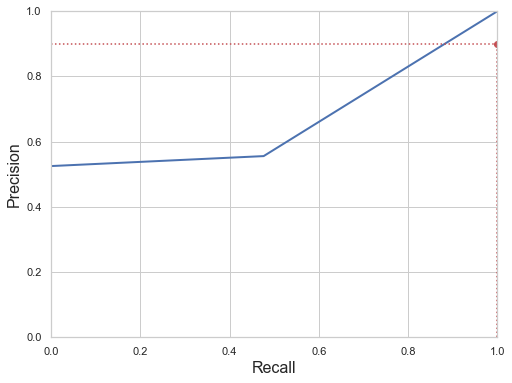

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



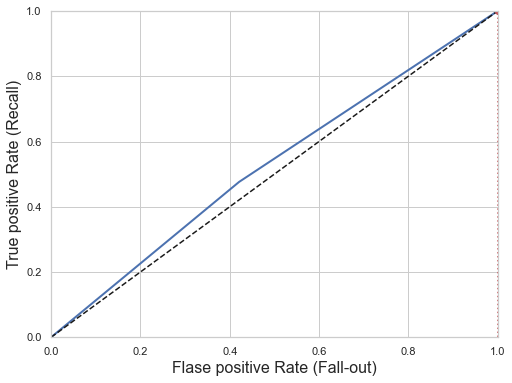

This is the roc_auc_score 0.4223057644110275
Creating RawArray with float64 data, n_channels=59, n_times=1906020
    Range : 0 ... 1906019 =      0.000 ...  1906.019 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 3.8e+03 (2.2e-16 eps * 59 dim * 2.9e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating

    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.838
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)

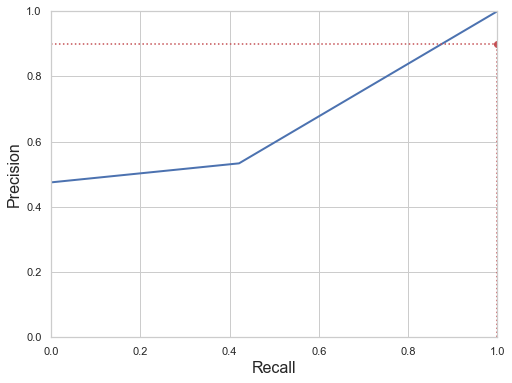

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



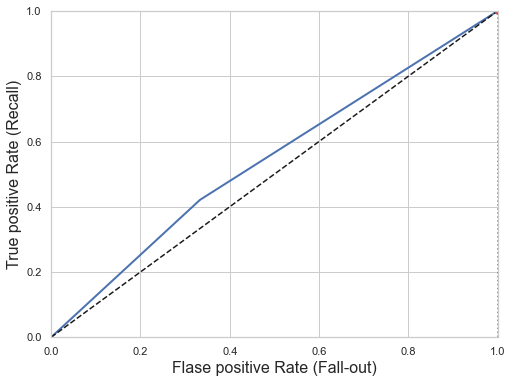

This is the roc_auc_score 0.5137362637362637


In [15]:
"""code reference from the mne documentation

"""

#this is the Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier


for f in fp:
    raw = creatRawArray(fp[f])
    events, labels = creatEventsArray(fp[f])
    
    
    # Apply band-pass filter
    raw.filter(low_freq, high_freq, fir_design='firwin', skip_by_annotation='edge')

    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True,
                        verbose=False)#, picks=picks)

    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2

    # Define a monte-carlo cross-validation generator (reduce variance):
    scores = []
    epochs_data = epochs.get_data()
    epochs_data_train = epochs_train.get_data()
    
    #shuffling the data
    cv = ShuffleSplit(5, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)
    
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(epochs_data_train, labels, test_size=0.2, random_state=42)

    # Assemble a classifier
    DTC = DecisionTreeClassifier(random_state=42, criterion='gini')
    csp = CSP(n_components=len(epochs.ch_names), reg=None, log=True, norm_trace=False)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = Pipeline([('CSP', csp), ('DTC', DTC)])
    scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
    
    print('---------------------------------------------------------------------------------------------------------')
    
    y_train_copy = y_train.copy()
    
    print(y_train)
    for i in range(len(y_train)):
        if -1 == y_train[i]:
            y_train_copy[i] = 0
        else:
            y_train_copy[i] = 1
    
    
    clf.fit(X_train, y_train_copy)
    pred = clf.predict(X_test)
    rmse_train = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("rmse_train:",rmse_train)
    r2_train = float(format(clf.score(X_train, y_train_copy),'.3f'))
    print("r2_train:",r2_train)
    # ar2_train = float(format(adjustedR2(clf.score(X_train, y_train),X_train.shape[0],3),'.3f'))
    mae_train=float(format((metrics.mean_absolute_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("mae_train:",mae_train)
    print('---------------------------------------------------------------------------------------------------------')

    y_test_copy = y_test.copy()
    
    print(y_test)
    for i in range(len(y_test)):
        if -1 == y_test[i]:
            y_test_copy[i] = 0
        else:
            y_test_copy[i] = 1
    print(y_test_copy)
    print('__________________________________________________________________________________')
    
    
    
    rmse_test = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("rmse_test:",rmse_test)
    r2_test = float(format(clf.score(X_test, y_test_copy),'.3f'))
    print("r2_test:",r2_test)
    # ar2_test = float(format(adjustedR2(clf.score(X_test, y_test),X_test.shape[0],3),'.3f'))
    mae_test=float(format((metrics.mean_absolute_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("mae_test:",mae_test)
    print('---------------------------------------------------------------------------------------------------------')

    cv_train = float(format(cross_val_score(clf,X_train, y_train_copy,cv=5).mean(),'.3f'))
    print("cv_train:",cv_train)
    print('---------------------------------------------------------------------------------------------------------')

    cv_test = float(format(cross_val_score(clf,X_test, y_test_copy,cv=5).mean(),'.3f'))
    print("cv_test:",cv_test)
    print('---------------------------------------------------------------------------------------------------------')
    

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
    #making the labels more generalized
    
    print('__________________________________________________________________________________')
    print(pred)
    
    #confusion matrix to know which class is being predicted
    print('__________________________________________________________________________')
    print('confusion matrix: ', confusion_matrix(y_test_copy, pred))
    print('__________________________________________________________________________')

#     print("precision_score",precision_score(pred, y_test_copy))
    print("precision_score",precision_score(y_test_copy, pred))
#     print("recall_score",recall_score(pred, y_test_copy))
    print("recall_score",recall_score(y_test_copy, pred))

#     print("f1_score",f1_score(pred, y_test_copy))
    print("f1_score",f1_score(y_test_copy, pred))
    
    
    
    
    #new territory from here
    y_probas = cross_val_predict(clf, X_test, y_test_copy, cv=5, method='predict_proba')
    
    y_test_dfs = y_probas[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_test_copy, y_test_dfs)
    #precisions, recalls, thresholds = precision_recall_curve(y_test_copy, pred)

    print('precisions', precisions)
    precisions.sort()
    print('precisions1 -', precisions[-1])
    print('precisions0 - ', precisions[0])
    print('precisions', precisions.size)
    print('recalls', recalls)
    recalls.sort()
    print('recalls1 -', recalls[-1])
    print('recalls0 -', recalls[0])
    print('recalls', recalls.size)
    print('thresholds', thresholds)
    thresholds.sort()
    print('thresholds1 -', thresholds[-1])
    print('thresholds0 -', thresholds[0])
    print('thresholds', thresholds.size)
    
    #threshold precision recall graph
    recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
    print(recall_90_precision)
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)-1]
    print(threshold_90_precision)


#     plt.figure(figsize=(8, 4))                                                                  
#     plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#     plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
#     plt.plot([-50, threshold_90_precision], [0.9, 0.9], "r:")                                
#     plt.plot([-50, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
#     plt.plot([threshold_90_precision], [0.9], "ro")                                           
#     plt.plot([threshold_90_precision], [recall_90_precision], "ro")                           
#     plt.show()

    plt.figure(figsize=(8, 6))
    plot_precision_vs_recall(precisions, recalls)
    plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
    plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
    plt.plot([recall_90_precision], [0.9], "ro")
    plt.show()
    
    #ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_copy, y_test_dfs)
    #fpr, tpr, thresholds = roc_curve(y_test_copy, pred)

    
    #plot curve
    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr, tpr)
    fpr_90 = fpr[np.argmax( tpr >= recall_90_precision)]
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
    plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
    plt.plot([fpr_90], [recall_90_precision], "ro")
    plt.show()
    
    from sklearn.metrics import roc_auc_score
    print('This is the roc_auc_score', roc_auc_score(pred, y_test_dfs))
    #roc_auc_score(y_test_copy, pred)

Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing r

Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.775
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 1.2e+03 (2.2e-16 eps * 59 dim * 9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3e+02 (2.2e-16 eps * 59 dim * 7.1e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e+03 (2.2e-16 eps * 59 dim * 8.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
R

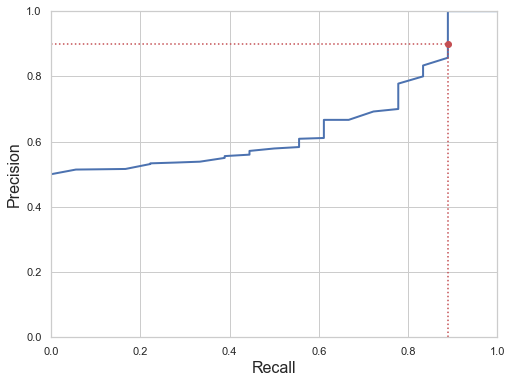

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



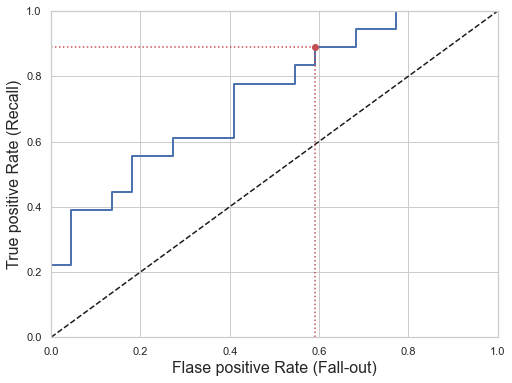

This is the roc_auc_score 0.7734375
Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 7.8e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covarian

    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.419
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 3.3e+02 (2.2e-16 eps * 59 dim * 2.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e+02 (2.2e-16 eps * 59 dim * 2.6e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e+02 (2.2e-16 eps * 59 dim * 2.6e+16  max singular value)
    Estimated rank (mag): 59

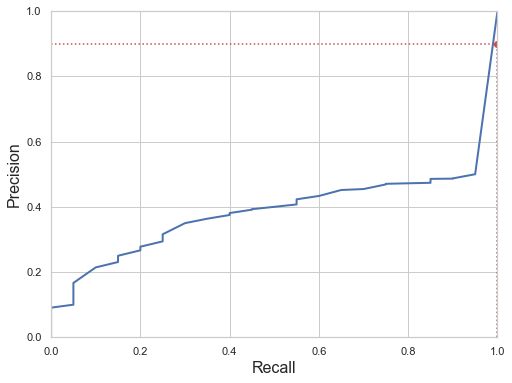

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



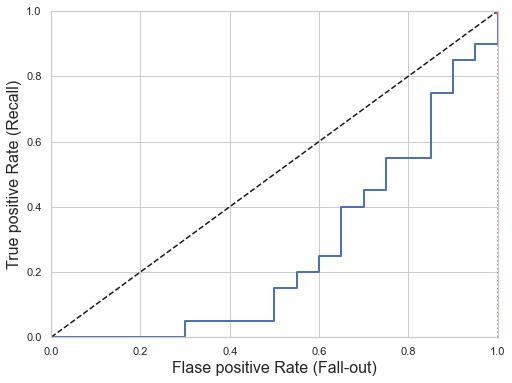

This is the roc_auc_score 0.6373626373626373
Creating RawArray with float64 data, n_channels=59, n_times=1906080
    Range : 0 ... 1906079 =      0.000 ...  1906.079 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating

    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.8
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 7.2e+02 (2.2e-16 eps * 59 dim * 5.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)
 

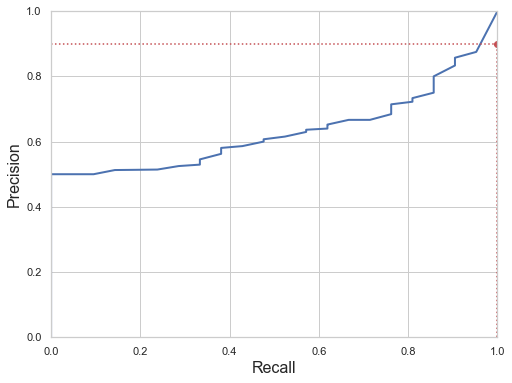

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



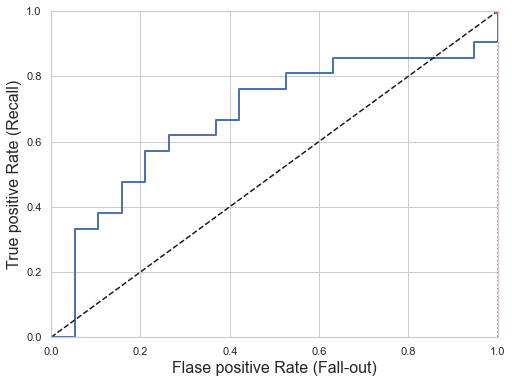

This is the roc_auc_score 0.7174999999999999
Creating RawArray with float64 data, n_channels=59, n_times=1906020
    Range : 0 ... 1906019 =      0.000 ...  1906.019 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 3.8e+03 (2.2e-16 eps * 59 dim * 2.9e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating

    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.9
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
 

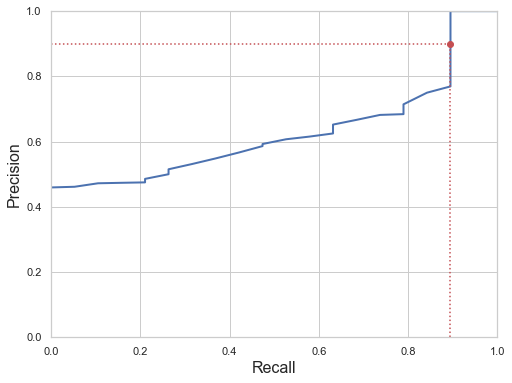

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



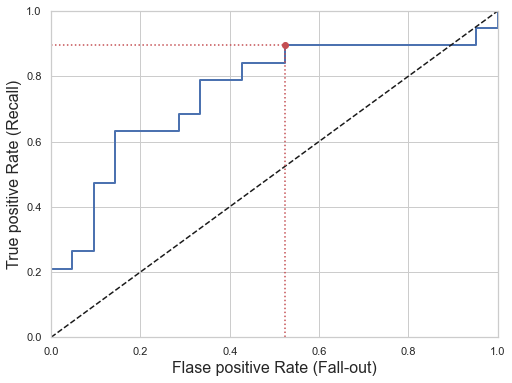

This is the roc_auc_score 0.75


In [16]:
"""code reference from the mne documentation

"""

#this is the Logistic regression
from sklearn.linear_model import LogisticRegression


for f in fp:
    raw = creatRawArray(fp[f])
    events, labels = creatEventsArray(fp[f])
    
    # Apply band-pass filter
    raw.filter(low_freq, high_freq, fir_design='firwin', skip_by_annotation='edge')
    
    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True,
                        verbose=False)#, picks=picks)

    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2

    # Define a monte-carlo cross-validation generator (reduce variance):
    scores = []
    epochs_data = epochs.get_data()
    epochs_data_train = epochs_train.get_data()
    
    #shuffling the data
    cv = ShuffleSplit(5, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)
    
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(epochs_data_train, labels, test_size=0.2, random_state=42)

    # Assemble a classifier
    LLR = LogisticRegression(random_state=42, penalty='l2', solver='lbfgs', verbose=0, n_jobs=1)
    csp = CSP(n_components=len(epochs.ch_names), reg=None, log=True, norm_trace=False)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = Pipeline([('CSP', csp), ('LLR', LLR)])
    scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
    
    print('---------------------------------------------------------------------------------------------------------')
    
    y_train_copy = y_train.copy()
    
    print(y_train)
    for i in range(len(y_train)):
        if -1 == y_train[i]:
            y_train_copy[i] = 0
        else:
            y_train_copy[i] = 1
    
    
    clf.fit(X_train, y_train_copy)
    pred = clf.predict(X_test)
    rmse_train = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("rmse_train:",rmse_train)
    r2_train = float(format(clf.score(X_train, y_train_copy),'.3f'))
    print("r2_train:",r2_train)
    # ar2_train = float(format(adjustedR2(clf.score(X_train, y_train),X_train.shape[0],3),'.3f'))
    mae_train=float(format((metrics.mean_absolute_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("mae_train:",mae_train)
    print('---------------------------------------------------------------------------------------------------------')

    y_test_copy = y_test.copy()
    
    print(y_test)
    for i in range(len(y_test)):
        if -1 == y_test[i]:
            y_test_copy[i] = 0
        else:
            y_test_copy[i] = 1
    print(y_test_copy)
    print('__________________________________________________________________________________')
    
    
    
    rmse_test = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("rmse_test:",rmse_test)
    r2_test = float(format(clf.score(X_test, y_test_copy),'.3f'))
    print("r2_test:",r2_test)
    # ar2_test = float(format(adjustedR2(clf.score(X_test, y_test),X_test.shape[0],3),'.3f'))
    mae_test=float(format((metrics.mean_absolute_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("mae_test:",mae_test)
    print('---------------------------------------------------------------------------------------------------------')

    cv_train = float(format(cross_val_score(clf,X_train, y_train_copy,cv=5).mean(),'.3f'))
    print("cv_train:",cv_train)
    print('---------------------------------------------------------------------------------------------------------')

    cv_test = float(format(cross_val_score(clf,X_test, y_test_copy,cv=5).mean(),'.3f'))
    print("cv_test:",cv_test)
    print('---------------------------------------------------------------------------------------------------------')
    

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
    #making the labels more generalized
    
    print('__________________________________________________________________________________')
    print(pred)
    
    #confusion matrix to know which class is being predicted
    print('__________________________________________________________________________')
    print('confusion matrix: ', confusion_matrix(y_test_copy, pred))
    print('__________________________________________________________________________')

#     print("precision_score",precision_score(pred, y_test_copy))
    print("precision_score",precision_score(y_test_copy, pred))
#     print("recall_score",recall_score(pred, y_test_copy))
    print("recall_score",recall_score(y_test_copy, pred))

#     print("f1_score",f1_score(pred, y_test_copy))
    print("f1_score",f1_score(y_test_copy, pred))
    
    
    
    
    #new territory from here
    y_test_dfs = cross_val_predict(clf, X_test, y_test_copy, cv=5, method='decision_function')

    precisions, recalls, thresholds = precision_recall_curve(y_test_copy, y_test_dfs)
    #precisions, recalls, thresholds = precision_recall_curve(y_test_copy, pred)

    print('precisions', precisions)
    precisions.sort()
    print('precisions1 -', precisions[-1])
    print('precisions0 - ', precisions[0])
    print('precisions', precisions.size)
    print('recalls', recalls)
    recalls.sort()
    print('recalls1 -', recalls[-1])
    print('recalls0 -', recalls[0])
    print('recalls', recalls.size)
    print('thresholds', thresholds)
    thresholds.sort()
    print('thresholds1 -', thresholds[-1])
    print('thresholds0 -', thresholds[0])
    print('thresholds', thresholds.size)
    
    #threshold precision recall graph
    recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
    print(recall_90_precision)
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)-1]
    print(threshold_90_precision)


#     plt.figure(figsize=(8, 4))                                                                  
#     plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#     plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
#     plt.plot([-50, threshold_90_precision], [0.9, 0.9], "r:")                                
#     plt.plot([-50, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
#     plt.plot([threshold_90_precision], [0.9], "ro")                                           
#     plt.plot([threshold_90_precision], [recall_90_precision], "ro")                           
#     plt.show()

    plt.figure(figsize=(8, 6))
    plot_precision_vs_recall(precisions, recalls)
    plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
    plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
    plt.plot([recall_90_precision], [0.9], "ro")
    plt.show()
    
    #ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_copy, y_test_dfs)
    #fpr, tpr, thresholds = roc_curve(y_test_copy, pred)

    
    #plot curve
    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr, tpr)
    fpr_90 = fpr[np.argmax( tpr >= recall_90_precision)]
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
    plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
    plt.plot([fpr_90], [recall_90_precision], "ro")
    plt.show()
    
    from sklearn.metrics import roc_auc_score
    print('This is the roc_auc_score', roc_auc_score(pred, y_test_dfs))
    #roc_auc_score(y_test_copy, pred)

Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing r

Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.738
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 1.2e+03 (2.2e-16 eps * 59 dim * 9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3e+02 (2.2e-16 eps * 59 dim * 7.1e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e+03 (2.2e-16 eps * 59 dim * 8.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
R

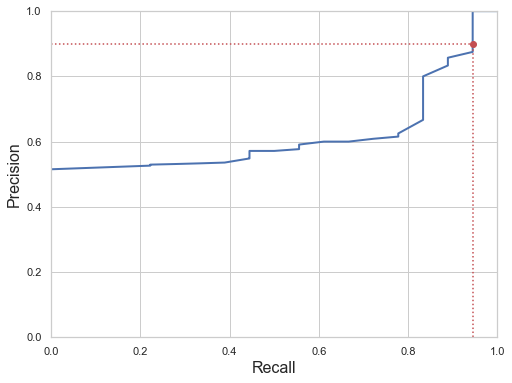

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



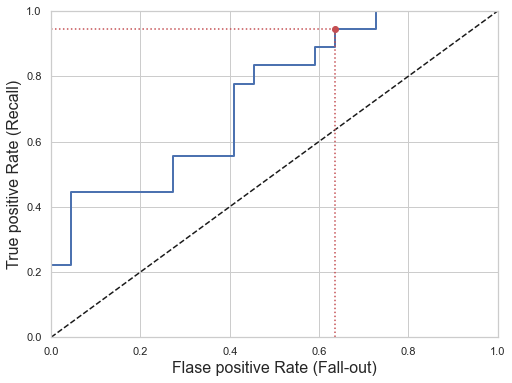

This is the roc_auc_score 0.74
Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 7.8e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance us

    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.406
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 3.3e+02 (2.2e-16 eps * 59 dim * 2.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e+02 (2.2e-16 eps * 59 dim * 2.6e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e+02 (2.2e-16 eps * 59 dim * 2.6e+16  max singular value)
    Estimated rank (mag): 59

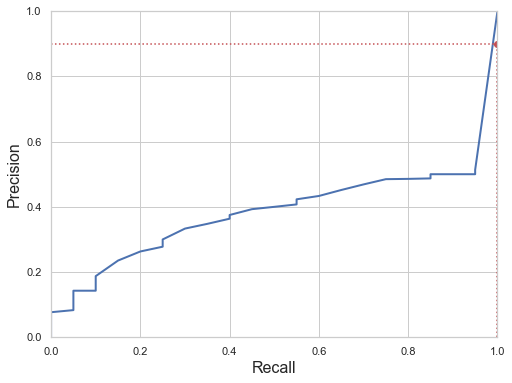

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



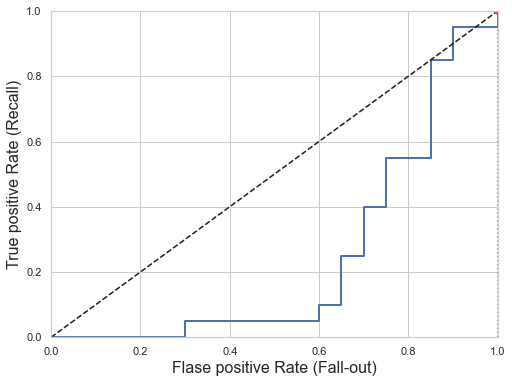

This is the roc_auc_score 0.5533333333333332
Creating RawArray with float64 data, n_channels=59, n_times=1906080
    Range : 0 ... 1906079 =      0.000 ...  1906.079 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating

    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.713
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 7.2e+02 (2.2e-16 eps * 59 dim * 5.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)

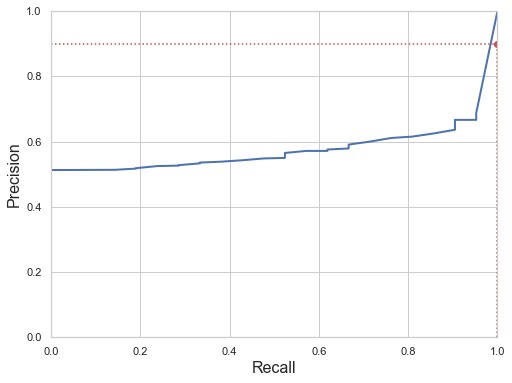

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



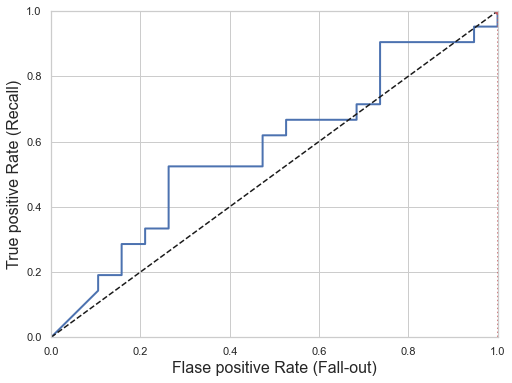

This is the roc_auc_score 0.5909090909090908
Creating RawArray with float64 data, n_channels=59, n_times=1906020
    Range : 0 ... 1906019 =      0.000 ...  1906.019 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 3.8e+03 (2.2e-16 eps * 59 dim * 2.9e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating

    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.781
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)

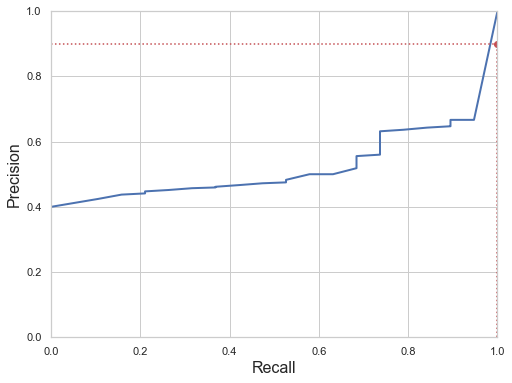

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



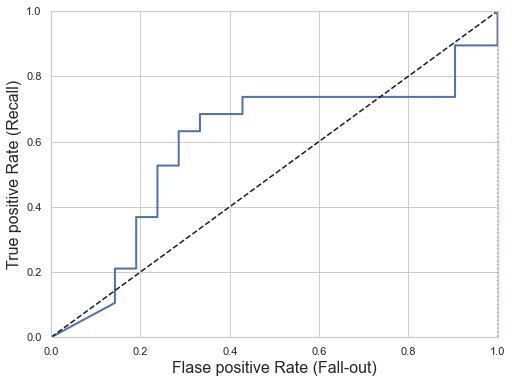

This is the roc_auc_score 0.6614583333333333


In [17]:
"""code reference from the mne documentation

"""

#this is the Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB


for f in fp:
    raw = creatRawArray(fp[f])
    events, labels = creatEventsArray(fp[f])
       
    
    # Apply band-pass filter
    raw.filter(low_freq, high_freq, fir_design='firwin', skip_by_annotation='edge')
    
    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True,
                        verbose=False)#, picks=picks)

    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2

    # Define a monte-carlo cross-validation generator (reduce variance):
    scores = []
    epochs_data = epochs.get_data()
    epochs_data_train = epochs_train.get_data()
    
    #shuffling the data
    cv = ShuffleSplit(5, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)
    
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(epochs_data_train, labels, test_size=0.2, random_state=42)

    # Assemble a classifier
    GNB = GaussianNB()
    csp = CSP(n_components=len(epochs.ch_names), reg=None, log=True, norm_trace=False)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = Pipeline([('CSP', csp), ('GNB', GNB)])
    scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
    
    print('---------------------------------------------------------------------------------------------------------')
    
    y_train_copy = y_train.copy()
    
    print(y_train)
    for i in range(len(y_train)):
        if -1 == y_train[i]:
            y_train_copy[i] = 0
        else:
            y_train_copy[i] = 1
    
    
    clf.fit(X_train, y_train_copy)
    pred = clf.predict(X_test)
    rmse_train = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("rmse_train:",rmse_train)
    r2_train = float(format(clf.score(X_train, y_train_copy),'.3f'))
    print("r2_train:",r2_train)
    # ar2_train = float(format(adjustedR2(clf.score(X_train, y_train),X_train.shape[0],3),'.3f'))
    mae_train=float(format((metrics.mean_absolute_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("mae_train:",mae_train)
    print('---------------------------------------------------------------------------------------------------------')

    y_test_copy = y_test.copy()
    
    print(y_test)
    for i in range(len(y_test)):
        if -1 == y_test[i]:
            y_test_copy[i] = 0
        else:
            y_test_copy[i] = 1
    print(y_test_copy)
    print('__________________________________________________________________________________')
    
    
    
    rmse_test = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("rmse_test:",rmse_test)
    r2_test = float(format(clf.score(X_test, y_test_copy),'.3f'))
    print("r2_test:",r2_test)
    # ar2_test = float(format(adjustedR2(clf.score(X_test, y_test),X_test.shape[0],3),'.3f'))
    mae_test=float(format((metrics.mean_absolute_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("mae_test:",mae_test)
    print('---------------------------------------------------------------------------------------------------------')

    cv_train = float(format(cross_val_score(clf,X_train, y_train_copy,cv=5).mean(),'.3f'))
    print("cv_train:",cv_train)
    print('---------------------------------------------------------------------------------------------------------')

    cv_test = float(format(cross_val_score(clf,X_test, y_test_copy,cv=5).mean(),'.3f'))
    print("cv_test:",cv_test)
    print('---------------------------------------------------------------------------------------------------------')
    

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
    #making the labels more generalized
    
    print('__________________________________________________________________________________')
    print(pred)
    
    #confusion matrix to know which class is being predicted
    print('__________________________________________________________________________')
    print('confusion matrix: ', confusion_matrix(y_test_copy, pred))
    print('__________________________________________________________________________')

#     print("precision_score",precision_score(pred, y_test_copy))
    print("precision_score",precision_score(y_test_copy, pred))
#     print("recall_score",recall_score(pred, y_test_copy))
    print("recall_score",recall_score(y_test_copy, pred))

#     print("f1_score",f1_score(pred, y_test_copy))
    print("f1_score",f1_score(y_test_copy, pred))
    
    
    
    
    #new territory from here
    y_probas = cross_val_predict(clf, X_test, y_test_copy, cv=5, method='predict_proba')
    
    y_test_dfs = y_probas[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_test_copy, y_test_dfs)
    #precisions, recalls, thresholds = precision_recall_curve(y_test_copy, pred)

    print('precisions', precisions)
    precisions.sort()
    print('precisions1 -', precisions[-1])
    print('precisions0 - ', precisions[0])
    print('precisions', precisions.size)
    print('recalls', recalls)
    recalls.sort()
    print('recalls1 -', recalls[-1])
    print('recalls0 -', recalls[0])
    print('recalls', recalls.size)
    print('thresholds', thresholds)
    thresholds.sort()
    print('thresholds1 -', thresholds[-1])
    print('thresholds0 -', thresholds[0])
    print('thresholds', thresholds.size)
    
    #threshold precision recall graph
    recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
    print(recall_90_precision)
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)-1]
    print(threshold_90_precision)


#     plt.figure(figsize=(8, 4))                                                                  
#     plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#     plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
#     plt.plot([-50, threshold_90_precision], [0.9, 0.9], "r:")                                
#     plt.plot([-50, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
#     plt.plot([threshold_90_precision], [0.9], "ro")                                           
#     plt.plot([threshold_90_precision], [recall_90_precision], "ro")                           
#     plt.show()

    plt.figure(figsize=(8, 6))
    plot_precision_vs_recall(precisions, recalls)
    plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
    plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
    plt.plot([recall_90_precision], [0.9], "ro")
    plt.show()
    
    #ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_copy, y_test_dfs)
    #fpr, tpr, thresholds = roc_curve(y_test_copy, pred)

    
    #plot curve
    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr, tpr)
    fpr_90 = fpr[np.argmax( tpr >= recall_90_precision)]
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
    plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
    plt.plot([fpr_90], [recall_90_precision], "ro")
    plt.show()
    
    from sklearn.metrics import roc_auc_score
    print('This is the roc_auc_score', roc_auc_score(pred, y_test_dfs))
    #roc_auc_score(y_test_copy, pred)

Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing r

Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.606
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 1.2e+03 (2.2e-16 eps * 59 dim * 9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3e+02 (2.2e-16 eps * 59 dim * 7.1e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e+03 (2.2e-16 eps * 59 dim * 8.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
R

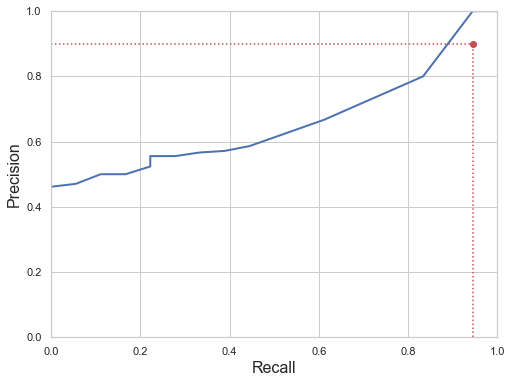

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



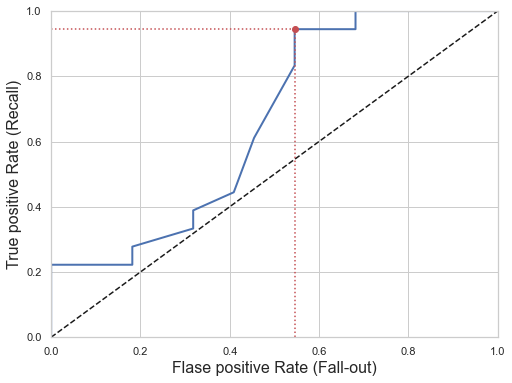

This is the roc_auc_score 0.819088319088319
Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 7.8e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating 

    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.481
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 3.3e+02 (2.2e-16 eps * 59 dim * 2.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e+02 (2.2e-16 eps * 59 dim * 2.6e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e+02 (2.2e-16 eps * 59 dim * 2.6e+16  max singular value)

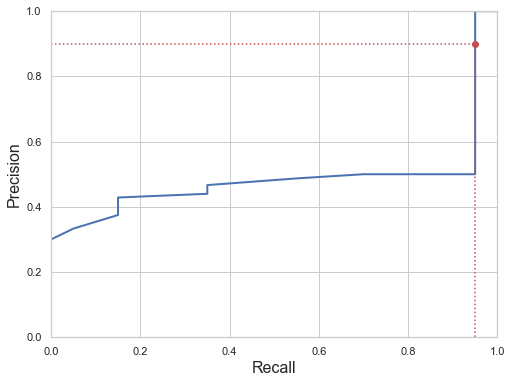

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



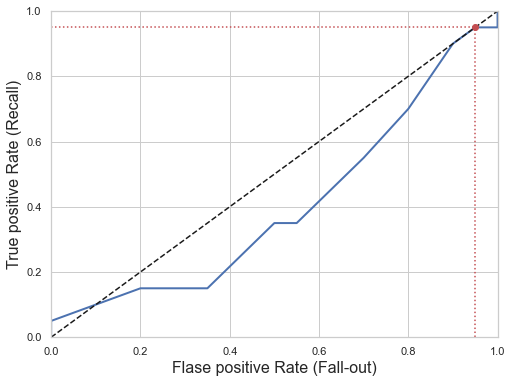

This is the roc_auc_score 0.31142857142857144
Creating RawArray with float64 data, n_channels=59, n_times=1906080
    Range : 0 ... 1906079 =      0.000 ...  1906.079 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimatin

    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.606
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 7.2e+02 (2.2e-16 eps * 59 dim * 5.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)

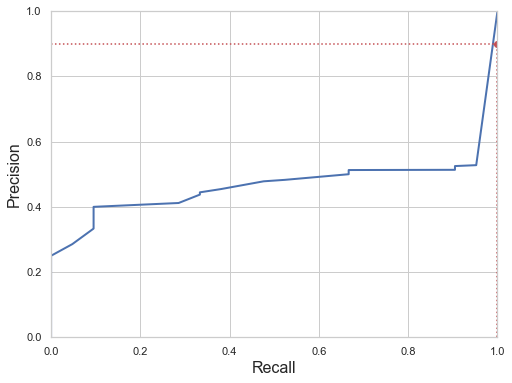

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



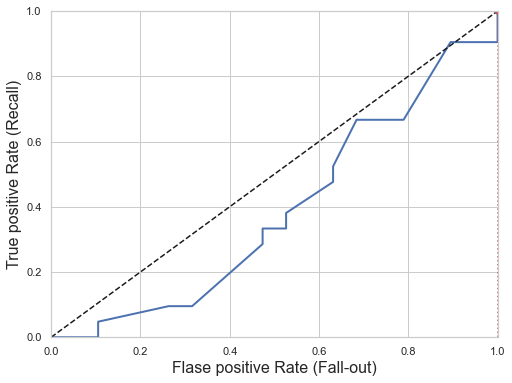

This is the roc_auc_score 0.475
Creating RawArray with float64 data, n_channels=59, n_times=1906020
    Range : 0 ... 1906019 =      0.000 ...  1906.019 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 sec)

Computing rank from data with rank=None
    Using tolerance 3.8e+03 (2.2e-16 eps * 59 dim * 2.9e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance u

    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
cv_train: 0.675
---------------------------------------------------------------------------------------------------------
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59

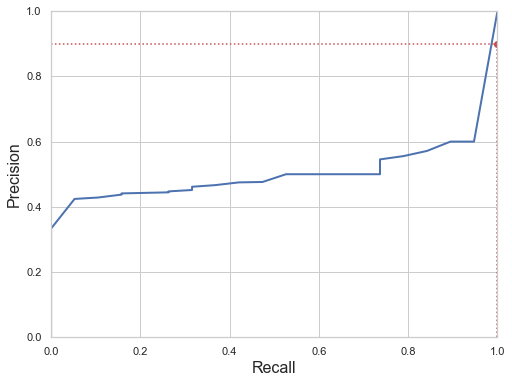

<ipython-input-8-b6e1e7c7d249>:5: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later

<ipython-input-8-b6e1e7c7d249>:6: MatplotlibDeprecationWarning:

Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later



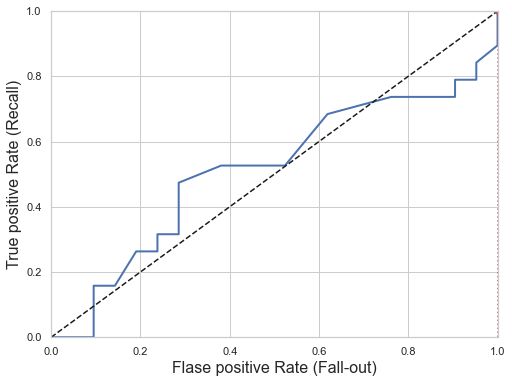

This is the roc_auc_score 0.3034188034188034


In [18]:
"""code reference from the mne documentation

"""

#this is the Bernoulli Naive Bayes
from sklearn.naive_bayes import BernoulliNB


for f in fp:
    raw = creatRawArray(fp[f])
    events, labels = creatEventsArray(fp[f])    
    
    # Apply band-pass filter
    raw.filter(low_freq, high_freq, fir_design='firwin', skip_by_annotation='edge')
    
    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True,
                        verbose=False)#, picks=picks)

    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2

    # Define a monte-carlo cross-validation generator (reduce variance):
    scores = []
    epochs_data = epochs.get_data()
    epochs_data_train = epochs_train.get_data()
    
    #shuffling the data
    cv = ShuffleSplit(5, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)
    
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(epochs_data_train, labels, test_size=0.2, random_state=42)

    # Assemble a classifier
    BNB = BernoulliNB()
    csp = CSP(n_components=len(epochs.ch_names), reg=None, log=True, norm_trace=False)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = Pipeline([('CSP', csp), ('BNB', BNB)])
    scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
    
    print('---------------------------------------------------------------------------------------------------------')
    
    y_train_copy = y_train.copy()
    
    print(y_train)
    for i in range(len(y_train)):
        if -1 == y_train[i]:
            y_train_copy[i] = 0
        else:
            y_train_copy[i] = 1
    
    
    clf.fit(X_train, y_train_copy)
    pred = clf.predict(X_test)
    rmse_train = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("rmse_train:",rmse_train)
    r2_train = float(format(clf.score(X_train, y_train_copy),'.3f'))
    print("r2_train:",r2_train)
    # ar2_train = float(format(adjustedR2(clf.score(X_train, y_train),X_train.shape[0],3),'.3f'))
    mae_train=float(format((metrics.mean_absolute_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("mae_train:",mae_train)
    print('---------------------------------------------------------------------------------------------------------')

    y_test_copy = y_test.copy()
    
    print(y_test)
    for i in range(len(y_test)):
        if -1 == y_test[i]:
            y_test_copy[i] = 0
        else:
            y_test_copy[i] = 1
    print(y_test_copy)
    print('__________________________________________________________________________________')
    
    
    
    rmse_test = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("rmse_test:",rmse_test)
    r2_test = float(format(clf.score(X_test, y_test_copy),'.3f'))
    print("r2_test:",r2_test)
    # ar2_test = float(format(adjustedR2(clf.score(X_test, y_test),X_test.shape[0],3),'.3f'))
    mae_test=float(format((metrics.mean_absolute_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("mae_test:",mae_test)
    print('---------------------------------------------------------------------------------------------------------')

    cv_train = float(format(cross_val_score(clf,X_train, y_train_copy,cv=5).mean(),'.3f'))
    print("cv_train:",cv_train)
    print('---------------------------------------------------------------------------------------------------------')

    cv_test = float(format(cross_val_score(clf,X_test, y_test_copy,cv=5).mean(),'.3f'))
    print("cv_test:",cv_test)
    print('---------------------------------------------------------------------------------------------------------')
    

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
    #making the labels more generalized
    
    print('__________________________________________________________________________________')
    print(pred)
    
    #confusion matrix to know which class is being predicted
    print('__________________________________________________________________________')
    print('confusion matrix: ', confusion_matrix(y_test_copy, pred))
    print('__________________________________________________________________________')

#     print("precision_score",precision_score(pred, y_test_copy))
    print("precision_score",precision_score(y_test_copy, pred))
#     print("recall_score",recall_score(pred, y_test_copy))
    print("recall_score",recall_score(y_test_copy, pred))

#     print("f1_score",f1_score(pred, y_test_copy))
    print("f1_score",f1_score(y_test_copy, pred))
    
    
    
    
    #new territory from here
    y_probas = cross_val_predict(clf, X_test, y_test_copy, cv=5, method='predict_proba')
    
    y_test_dfs = y_probas[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_test_copy, y_test_dfs)
    #precisions, recalls, thresholds = precision_recall_curve(y_test_copy, pred)

    print('precisions', precisions)
    precisions.sort()
    print('precisions1 -', precisions[-1])
    print('precisions0 - ', precisions[0])
    print('precisions', precisions.size)
    print('recalls', recalls)
    recalls.sort()
    print('recalls1 -', recalls[-1])
    print('recalls0 -', recalls[0])
    print('recalls', recalls.size)
    print('thresholds', thresholds)
    thresholds.sort()
    print('thresholds1 -', thresholds[-1])
    print('thresholds0 -', thresholds[0])
    print('thresholds', thresholds.size)
    
    #threshold precision recall graph
    recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
    print(recall_90_precision)
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)-1]
    print(threshold_90_precision)


#     plt.figure(figsize=(8, 4))                                                                  
#     plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#     plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
#     plt.plot([-50, threshold_90_precision], [0.9, 0.9], "r:")                                
#     plt.plot([-50, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
#     plt.plot([threshold_90_precision], [0.9], "ro")                                           
#     plt.plot([threshold_90_precision], [recall_90_precision], "ro")                           
#     plt.show()

    plt.figure(figsize=(8, 6))
    plot_precision_vs_recall(precisions, recalls)
    plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
    plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
    plt.plot([recall_90_precision], [0.9], "ro")
    plt.show()
    
    #ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_copy, y_test_dfs)
    #fpr, tpr, thresholds = roc_curve(y_test_copy, pred)

    
    #plot curve
    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr, tpr)
    fpr_90 = fpr[np.argmax( tpr >= recall_90_precision)]
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
    plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
    plt.plot([fpr_90], [recall_90_precision], "ro")
    plt.show()
    
    from sklearn.metrics import roc_auc_score
    print('This is the roc_auc_score', roc_auc_score(pred, y_test_dfs))
    #roc_auc_score(y_test_copy, pred)